# Load data

In [ ]:
import h5py
import numpy as np
import os

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
L_list=np.arange(8,18,2)

In [ ]:
dirpath='Data/Bitstring'

In [ ]:
f_1_3={}
for L in L_list:
    f_1_3[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(1-3,2-3)_seed0_64_wf.hdf5'))

In [ ]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))

In [ ]:
f_0[8]['wf_8']

In [ ]:
f_0[8]['wf_8'][11].shape

In [ ]:
# for L in L_list:
#     f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En100000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))
# f_C_1_3=h5py.File(os.path.join(dirpath,'CT_En100000_pctrl(0.00,1.00,21)_L(10,14,2)_xj(1-3,2-3)_C.hdf5'))
# f_C_0=h5py.File(os.path.join(dirpath,'CT_En100000_pctrl(0.00,1.00,21)_L(10,14,2)_xj(0)_C.hdf5'))

f_C_1_3=h5py.File(os.path.join(dirpath,'CT_En10000_pctrl(0.00,1.00,21)_L(8,10,2)_xj(1-3,2-3)_C.hdf5'))

f_C_0=h5py.File(os.path.join(dirpath,'CT_En100000_pctrl(0.00,1.00,21)_L(8,10,2)_xj(0)_C.hdf5'))


In [ ]:
def convert_to_re_im(data):
    return np.concatenate([(data).real,(data).real],axis=-1)
def convert_to_abs2(data):
    return np.abs(data)**2


In [ ]:
f_1_3[8]['wf_8'].shape

In [ ]:
def convert_bitstring_to_dw(L,ZZ=False):
    # The distance of the leftmost "1" to the right
    dw=[]
    for bitstring in range(2**L):
        pos=L-1
        if ZZ:
            bitstring=~(bitstring^(bitstring>>1))
            pos-=1
        while pos>-1 and bitstring&(1<<pos)==0:
            pos-=1
        dw.append(pos+1)
    return dw

# Test classical

In [ ]:
f_C_0.keys()

In [ ]:
f_C_0['L_list'][:]

In [ ]:
f_C_0['p_ctrl_list'][:]

In [ ]:
f_C_0['vec'].shape

In [ ]:
basis,counts=np.unique(f_C_0['vec'][0,12],return_counts=True)

In [ ]:
plt.bar(x=basis, height=counts,width=1)
plt.yscale('log')
plt.xscale('log')

In [ ]:
basis,counts=np.unique(f_C['vec'][0,10],return_counts=True)

# Connected part

In [ ]:
p_proj_list=np.linspace(0,1,21)
p_ctrl_list=np.linspace(0,1,21)

In [ ]:
dw_0={L:np.array(convert_bitstring_to_dw(L)) for L in L_list}

In [ ]:
def connected_moment(dw_0,f_0,L_list,p_ctrl_list):
    f_FDW_list=np.zeros((len(L_list),p_ctrl_list.shape[0]))
    f22_FDW_list=np.zeros((len(L_list),p_ctrl_list.shape[0]))
    f4_FDW_list=np.zeros((len(L_list),p_ctrl_list.shape[0]))
    for L_idx,L in enumerate(L_list):
        for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
            wf_abs=(convert_to_abs2(f_0[L][f'wf_{L}'][p_ctrl_idx,0,0,...,0]).reshape((-1,2000))) # 256,2000
            # f_FDW=np.mean(dw_0[L]@wf_abs)
            # f2_FDW=np.mean(((dw_0[L]-f_FDW)**2@wf_abs)**2)
            # f4_FDW=np.mean((dw_0[L]-f_FDW)**4@wf_abs)

            f_FDW=(dw_0[L]@wf_abs)  # 2000,
            F_f=(dw_0[L][:,np.newaxis]-f_FDW)
            f22_FDW=np.mean(np.sum(F_f**2*wf_abs,axis=0)**2)
            f4_FDW=np.mean(np.sum(F_f*wf_abs,axis=0)**4)


            # f2_FDW=np.mean((np.sum((dw_0[L][:,np.newaxis]-f_FDW)**2*wf_abs,axis=0))**2)
            # f4_FDW=np.mean((np.sum((dw_0[L][:,np.newaxis]-f_FDW)**4*wf_abs,axis=0)))


            f_FDW_list[L_idx,p_ctrl_idx]=np.mean(f_FDW)
            f22_FDW_list[L_idx,p_ctrl_idx]=(f22_FDW)
            f4_FDW_list[L_idx,p_ctrl_idx]=(f4_FDW)
    return f_FDW_list,f22_FDW_list,f4_FDW_list


In [ ]:
f_FDW_0_list,f22_FDW_0_list,f4_FDW_0_list=connected_moment(dw_0,f_0,L_list,p_ctrl_list)

In [ ]:
plt.plot(p_ctrl_list,f22_FDW_0_list.T)

In [ ]:
plt.plot(p_ctrl_list,f4_FDW_list.T)

In [ ]:
plt.plot(p_ctrl_list,(f22_FDW_list-f4_FDW_list).T)
plt.grid('on')
plt.axvline(x=1/2)

In [ ]:
fig,ax=plt.subplots()

for (L_idx,L),color in zip(enumerate(L_list),['r','b','g','c','m','y','k']):
    ax.plot(p_ctrl_list,(f22_FDW_0_list[L_idx]-f4_FDW_0_list[L_idx]),label=f'L={L}',color=color)
    # ax.plot(p_ctrl_list,np.sqrt(f4_FDW_0_list[L_idx]-f2_FDW_0_list[L_idx])/np.log(L),label=f'L={L}',color=color)
ax.grid('on')
ax.axvline(x=1/2)
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel('Connected of 4th moment')

In [ ]:
dw_1_3={L:np.array(convert_bitstring_to_dw(L,ZZ=True)) for L in L_list}

In [ ]:
f_FDW_1_3_list,f22_FDW_1_3_list,f4_FDW_1_3_list=connected_moment(dw_1_3,f_1_3,L_list,p_ctrl_list)

In [ ]:
fig,ax=plt.subplots()
for (L_idx,L),color in zip(enumerate(L_list),['r','b','g','c','m','y','k']):
    ax.plot(p_ctrl_list,(f22_FDW_1_3_list[L_idx]-f4_FDW_1_3_list[L_idx]),label=f'L={L}',color=color)
    # ax.plot(p_ctrl_list,np.sqrt(f4_FDW_1_3_list[L_idx]-f2_FDW_1_3_list[L_idx])/np.log(L),label=f'L={L}',color=color)
ax.grid('on')
ax.axvline(x=1/2)
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel('Connected of 4th moment')


## Another try: mutual information

I3(A:B:C)=I2(A:B)+I2(A:C)-I2(A:BC)
I2(A:B)> 1/2 <O_A O_B>^2 / |O_A|^2 |O_B|^2

### Order Parameter

In [ ]:
def Z(L,regime,):
    return np.array([regime[1]-regime[0]-2*bin(idx).replace('0b','').zfill(L)[regime[0]:regime[1]].count('1') for idx in range(2**L)])


In [ ]:
def ZZ(L,regime,):
    ZZ_list=[]
    for idx in range(2**L):
        bitstring_reg=bin(idx).replace('0b','').zfill(L)
        ZZ_list.append(-np.sum([(1-2*int(i))*(1-2*int(j)) for i,j in zip(bitstring_reg[regime[0]:regime[1]-1] , bitstring_reg[regime[0]+1:regime[1]])]))
    return np.array(ZZ_list)

In [ ]:
def bitstring_to_dw(bitstring,L,ZZ):
    pos=L-1
    if ZZ:
        bitstring=~(bitstring^(bitstring>>1))
        pos-=1
    while pos>-1 and bitstring&(1<<pos)==0:
        pos-=1
    return pos+1


In [ ]:
{bin(x).replace('0b','').zfill(4):bitstring_to_dw(x,L=4,ZZ=False) for x in range(2**4)}

In [ ]:
{bin(x).replace('0b','').zfill(4):bitstring_to_dw(x,L=4,ZZ=True) for x in range(2**4)}

In [ ]:
def FDW(L,regime,ZZ):
    # FDW
    FDW_list=[]
    for idx in range(2**L):
        bitstring_reg=bin(idx).replace('0b','').zfill(L)[regime[0]:regime[1]]
        FDW_list.append( bitstring_to_dw(int(bitstring_reg,2),L=regime[1]-regime[0],ZZ=ZZ))
    return np.array(FDW_list)

In [ ]:
{bin(idx).replace('0b','').zfill(4):fdw for idx,fdw in enumerate(FDW(4,(0,2),ZZ=True))}

### Connected

In [ ]:
def average_Z(wf,OP):
    wf_abs2=convert_to_abs2(wf).reshape((-1,2000))
    return np.mean(OP@wf_abs2)
def connected(wf,OP1,OP2):
    wf_abs2=convert_to_abs2(wf).reshape((-1,2000))
    return np.mean(((OP1*OP2) @ (wf_abs2)  - (OP1 @ wf_abs2)  * (OP2@wf_abs2) )**2)
def connected2(wf,OP1,OP2):
    wf_abs2=convert_to_abs2(wf).reshape((-1,2000)) # state, circuit
    return np.mean(((OP1*OP2) @ (wf_abs2))**2- (OP1 @ wf_abs2)**2 * (OP2 @ wf_abs2)**2)
def connected3(wf,OP1,OP2):
    wf_abs2=convert_to_abs2(wf).reshape((-1,2000))
    conected_state=((OP1*OP2) @ (wf_abs2))**2- (OP1 @ wf_abs2)**2 * (OP2 @ wf_abs2)**2
    return np.mean(conected_state**2)-np.mean(conected_state)**2
def connected4(wf,OP1,OP2):
    wf_abs2=convert_to_abs2(wf).reshape((-1,2000))
    conected_state=((OP1*OP2) @ (wf_abs2))**2- (OP1 @ wf_abs2)**2 * (OP2 @ wf_abs2)**2
    return np.mean(conected_state**4)-np.mean(conected_state**2)**2
def I2(wf,OP1,OP2):
    connected_C=connected(wf,OP1,OP2)
    return 1/2* connected_C / (np.sum(np.abs(OP1))**2 * np.sum(np.abs(OP2))**2)

def I3(wf,OP1,OP2,OP3,OP23):
    return I2(wf,OP1,OP2) +I2(wf,OP1,OP3) - I2(wf,OP1,OP23)
    

In [ ]:
np.sum(np.abs(OP1))**2

In [ ]:
np.sum(np.abs(OP2))**2

In [ ]:
np.sum(np.abs(OP23))**2

In [ ]:
np.sum(np.abs(OP1+OP2))**2

In [ ]:
L=4
OP1=Z(L,(L//4*0,L//4*1))
OP2=Z(L,(L//4*1,L//4*2))
OP3=Z(L,(L//4*2,L//4*3))

In [ ]:
np.sum(np.abs(OP2+OP3))**2

In [ ]:
L=4
OP=Z(L,(L//4*0,L//4*4))/L

In [ ]:
{bin(idx).replace('0b','').zfill(L):o for idx, o in enumerate(OP)}

In [ ]:
L_list=[8,12,16]

In [ ]:
def connected_correlation(f_0,connected,Z,partition='quarter'):
    connected_list=np.zeros((len(L_list),len(p_ctrl_list)))
    for L_idx, L in tqdm(enumerate(L_list)):
        OP={'quarter':[Z(L,(L//4*0,L//4*1)),Z(L,(L//4*2,L//4*3))],
        'half':[Z(L,(L//2*0,L//2*1)),Z(L,(L//2,L//2*2))],
        'full':[Z(L,(0,L)),Z(L,(0,L))]}
        for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
            connected_list[L_idx,p_ctrl_idx]=(connected(f_0[L][f'wf_{L}'][p_ctrl_idx,0,0,...,0],OP[partition][0],OP[partition][1]))
    return connected_list
            

In [ ]:
def plot_connected(connected_1_3_list,ylabel):
    # ylabel= r'$\mathbb{E}_C[\langle O_{[0,\frac{L}{4})} O_{[\frac{L}{2},\frac{3L}{4})}\rangle_c]$'
    # ylabel= r'$\mathbb{E}_C[ {\langle{O_[0,\frac{L}{4}) O_{[\frac{L}{2},\frac{3L}{4})}}}\rangle^2-\langle{O_{[0,\frac{L}{4})}}\rangle^2 \langle{O_{[\frac{L}{2},\frac{3L}{4})}\rangle}^2 ]$'
    fig,ax=plt.subplots()
    for L_idx,L in enumerate(L_list):
        ax.plot(p_ctrl_list,connected_1_3_list[L_idx],label=f'L={L}')
    ax.legend()
    ax.set_xlabel('$p_{ctrl}$')
    ax.set_ylabel(ylabel)
    ax.grid('on')

### 0

In [ ]:
connected_0_quarter_list=connected_correlation(f_0,connected,Z,partition='quarter')

In [ ]:
plot_connected(connected_0_quarter_list,r'$\mathbb{E}_C[\langle O_{[0,\frac{L}{4})} O_{[\frac{L}{2},\frac{3L}{4})}\rangle_c]$')

In [ ]:
connected2_0_quarter_list=connected_correlation(f_0,connected2,Z,partition='quarter')

In [ ]:
plot_connected(connected2_0_quarter_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_[0,\frac{L}{4}) O_{[\frac{L}{2},\frac{3L}{4})}}}\rangle^2-\langle{O_{[0,\frac{L}{4})}}\rangle^2 \langle{O_{[\frac{L}{2},\frac{3L}{4})}\rangle}^2 ]$')

In [ ]:
connected3_0_quarter_list=connected_correlation(f_0,connected3,Z,partition='quarter')

In [ ]:
plot_connected(connected3_0_quarter_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c]^2 $')

In [ ]:
connected4_0_quarter_list=connected_correlation(f_0,connected4,Z,partition='quarter')

In [ ]:
plot_connected(connected4_0_quarter_list,ylabel=r'$\mathbb{E}_C[ \langle{O_A O_B}\rangle_c^4] -\mathbb{E}_C[\langle{O_A O_B}\rangle_c^2]^2 $')

## This is a bit weird...

In [ ]:
connected_0_full_list=connected_correlation(f_0,connected,Z,partition='full')

In [ ]:
plot_connected(connected_0_full_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L)} O_{[0,L)}\rangle_c]$')

In [ ]:
connected2_0_full_list=connected_correlation(f_0,connected2,Z,partition='full')

In [ ]:
plot_connected(connected2_0_full_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L)} O_{[0,L)]}}}\rangle^2-\langle{O_{[0,L)}}\rangle^2 \langle{O_{[0,L)]}\rangle}^2 ]$')

In [ ]:
connected3_0_full_list=connected_correlation(f_0,connected3,Z,partition='full')

In [ ]:
plot_connected(connected3_0_full_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c]^2 $')

In [ ]:
connected_0_half_list=connected_correlation(f_0,connected,Z,partition='half')

In [ ]:
plot_connected(connected_0_half_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L/2)} O_{[L/2,L)}\rangle_c]$')

In [ ]:
connected2_0_half_list=connected_correlation(f_0,connected2,Z,partition='half')

In [ ]:
plot_connected(connected2_0_half_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L/2)} O_{[L/2,L)]}}}\rangle^2-\langle{O_{[0,L/2)}}\rangle^2 \langle{O_{[L/2,L)]}\rangle}^2 ]$')

In [ ]:
connected3_0_half_list=connected_correlation(f_0,connected3,Z,partition='half')

In [ ]:
plot_connected(connected3_0_half_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c]^2 $')

In [ ]:
from functools import partial

In [ ]:
connected_0_F_full_list=connected_correlation(f_0,connected,partial(FDW,ZZ=False),partition='full')

In [ ]:
plot_connected(connected_0_F_full_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L)} O_{[0,L)}\rangle_c]$')

In [ ]:
connected2_0_F_full_list=connected_correlation(f_0,connected2,partial(FDW,ZZ=False),partition='full')

In [ ]:
plot_connected(connected2_0_F_full_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L)} O_{[L,L)]}}}\rangle^2-\langle{O_{[0,L)}}\rangle^2 \langle{O_{[L,L)]}\rangle}^2 ]$')

In [ ]:
connected3_0_F_full_list=connected_correlation(f_0,connected3,partial(FDW,ZZ=False),partition='full')

In [ ]:
plot_connected(connected3_0_F_full_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L)} O_{[0,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L)} O_{[0,L)}}\rangle_c]^2 $')

In [ ]:
connected_0_F_half_list=connected_correlation(f_0,connected,partial(FDW,ZZ=False),partition='half')

In [ ]:
plot_connected(connected_0_F_half_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L/2)} O_{[L/2,L)}\rangle_c]$')

In [ ]:
connected2_0_F_half_list=connected_correlation(f_0,connected2,partial(FDW,ZZ=False),partition='half')

In [ ]:
plot_connected(connected2_0_F_half_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L/2)} O_{[L/2,L)]}}}\rangle^2-\langle{O_{[0,L/2)}}\rangle^2 \langle{O_{[L/2,L)]}\rangle}^2 ]$')

In [ ]:
connected3_0_F_half_list=connected_correlation(f_0,connected3,partial(FDW,ZZ=False),partition='half')

In [ ]:
plot_connected(connected3_0_F_half_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c]^2 $')

In [ ]:
connected_0_F_quarter_list=connected_correlation(f_0,connected,partial(FDW,ZZ=False),partition='quarter')

In [ ]:
plot_connected(connected_0_F_quarter_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L/4)} O_{[L/2,3L/4)}\rangle_c]$')

In [ ]:
connected2_0_F_quarter_list=connected_correlation(f_0,connected2,partial(FDW,ZZ=False),partition='quarter')

In [ ]:
plot_connected(connected2_0_F_quarter_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L/4)} O_{[L/2,3L/4)]}}}\rangle^2-\langle{O_{[0,L/4)}}\rangle^2 \langle{O_{[L/2,3L/4)]}\rangle}^2 ]$')

In [ ]:
connected3_0_F_quarter_list=connected_correlation(f_0,connected3,partial(FDW,ZZ=False),partition='quarter')

In [ ]:
plot_connected(connected3_0_F_quarter_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c]^2 $')

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    ax.plot(p_ctrl_list,I2_list[L_idx],label=f'L={L}')
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\tilde{I_3}$')
# ax.set_ylim([0,1e-6])

ax.grid('on')

In [ ]:
fig,ax=plt.subplots()
for L_idx,L in enumerate(L_list):
    if L_idx>1:
        ax.plot(p_ctrl_list,I3_list[L_idx],label=f'L={L}')
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\tilde{I_3}$')
# ax.set_ylim([0,1e-6])

ax.grid('on')

### 1-3

In [ ]:
connected_1_3_quarter_list=connected_correlation(f_1_3,connected,ZZ,partition='quarter')

In [ ]:
plot_connected(connected_1_3_quarter_list,r'$\mathbb{E}_C[\langle O_{[0,\frac{L}{4})} O_{[\frac{L}{2},\frac{3L}{4})}\rangle_c]$')

In [ ]:
connected2_1_3_quarter_list=connected_correlation(f_1_3,connected2,ZZ,partition='quarter')


In [ ]:
plot_connected(connected2_1_3_quarter_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_[0,\frac{L}{4}) O_{[\frac{L}{2},\frac{3L}{4})}}}\rangle^2-\langle{O_{[0,\frac{L}{4})}}\rangle^2 \langle{O_{[\frac{L}{2},\frac{3L}{4})}\rangle}^2 ]$')

In [ ]:
connected3_1_3_quarter_list=connected_correlation(f_1_3,connected3,ZZ,partition='quarter')

In [ ]:
plot_connected(connected3_1_3_quarter_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c]^2 $')

In [ ]:
connected_1_3_full_list=connected_correlation(f_1_3,connected,ZZ,partition='full')

In [ ]:
plot_connected(connected_1_3_full_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L)} O_{[0,L)}\rangle_c]$')

In [ ]:
connected2_1_3_full_list=connected_correlation(f_1_3,connected2,ZZ,partition='full')

In [ ]:
plot_connected(connected2_1_3_full_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L)} O_{[0,L)]}}}\rangle^2-\langle{O_{[0,L)}}\rangle^2 \langle{O_{[0,L)]}\rangle}^2 ]$')

In [ ]:
connected3_1_3_full_list=connected_correlation(f_1_3,connected3,ZZ,partition='full')

In [ ]:
plot_connected(connected3_1_3_full_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L)} O_{[0,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L)} O_{[0,L)}}\rangle_c]^2 $')

In [ ]:
connected_1_3_half_list=connected_correlation(f_1_3,connected,ZZ,partition='half')


In [ ]:
plot_connected(connected_1_3_half_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L/2)} O_{[L/2,L)}\rangle_c]$')

In [ ]:
connected2_1_3_half_list=connected_correlation(f_1_3,connected2,ZZ,partition='half')


In [ ]:
plot_connected(connected2_1_3_half_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L/2)} O_{[L/2,L)]}}}\rangle^2-\langle{O_{[0,L/2)}}\rangle^2 \langle{O_{[L/2,L)]}\rangle}^2 ]$')

In [ ]:
connected3_1_3_half_list=connected_correlation(f_1_3,connected3,ZZ,partition='half')


In [ ]:
plot_connected(connected3_1_3_half_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c]^2 $')

In [ ]:
connected_1_3_F_full_list=connected_correlation(f_1_3,connected,partial(FDW,ZZ=True),partition='full')

In [ ]:
plot_connected(connected_1_3_F_full_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L)} O_{[0,L)}\rangle_c]$')

In [ ]:
connected2_1_3_F_full_list=connected_correlation(f_1_3,connected2,partial(FDW,ZZ=True),partition='full')

In [ ]:
plot_connected(connected2_1_3_F_full_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L)} O_{[L,L)]}}}\rangle^2-\langle{O_{[0,L)}}\rangle^2 \langle{O_{[L,L)]}\rangle}^2 ]$')

In [ ]:
connected3_1_3_F_full_list=connected_correlation(f_1_3,connected3,partial(FDW,ZZ=True),partition='full')

In [ ]:
plot_connected(connected3_1_3_F_full_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L)} O_{[0,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L)} O_{[0,L)}}\rangle_c]^2 $')

In [ ]:
connected_1_3_F_half_list=connected_correlation(f_1_3,connected,partial(FDW,ZZ=True),partition='half')

In [ ]:
plot_connected(connected_1_3_F_half_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L/2)} O_{[L/2,L)}\rangle_c]$')

In [ ]:
connected2_1_3_F_half_list=connected_correlation(f_1_3,connected2,partial(FDW,ZZ=True),partition='half')

In [ ]:
plot_connected(connected2_1_3_F_half_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L/2)} O_{[L/2,L)]}}}\rangle^2-\langle{O_{[0,L/2)}}\rangle^2 \langle{O_{[L/2,L)]}\rangle}^2 ]$')

In [ ]:
connected3_1_3_F_half_list=connected_correlation(f_1_3,connected3,partial(FDW,ZZ=True),partition='half')

In [ ]:
plot_connected(connected3_1_3_F_half_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/2)} O_{[L/2,L)}}\rangle_c]^2 $')

In [ ]:
connected_1_3_F_quarter_list=connected_correlation(f_1_3,connected,partial(FDW,ZZ=True),partition='quarter')

In [ ]:
plot_connected(connected_1_3_F_quarter_list,ylabel=r'$\mathbb{E}_C[\langle O_{[0,L/4)} O_{[L/2,3L/4)}\rangle_c]$')

In [ ]:
connected2_1_3_F_quarter_list=connected_correlation(f_1_3,connected2,partial(FDW,ZZ=True),partition='quarter')

In [ ]:
plot_connected(connected2_1_3_F_quarter_list,ylabel=r'$\mathbb{E}_C[ {\langle{O_{[0,L/4)} O_{[L/2,3L/4)]}}}\rangle^2-\langle{O_{[0,L/4)}}\rangle^2 \langle{O_{[L/2,3L/4)]}\rangle}^2 ]$')

In [ ]:
connected3_1_3_F_quarter_list=connected_correlation(f_1_3,connected3,partial(FDW,ZZ=True),partition='quarter')

In [ ]:
plot_connected(connected3_1_3_F_quarter_list,ylabel=r'$\mathbb{E}_C[ \langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c^2] -\mathbb{E}_C[\langle{O_{[0,L/4)} O_{[L/2,3L/4)}}\rangle_c]^2 $')

In [ ]:
def connected_moment(dw_0,f_0,L_list,p_ctrl_list):
    f_FDW_list=np.zeros((len(L_list),p_ctrl_list.shape[0]))
    f22_FDW_list=np.zeros((len(L_list),p_ctrl_list.shape[0]))
    f4_FDW_list=np.zeros((len(L_list),p_ctrl_list.shape[0]))
    for L_idx,L in enumerate(L_list):
        for p_ctrl_idx,p_ctrl in enumerate(p_ctrl_list):
            wf_abs=(convert_to_abs2(f_0[L][f'wf_{L}'][p_ctrl_idx,0,0,...,0]).reshape((-1,2000))) # 256,2000
            # f_FDW=np.mean(dw_0[L]@wf_abs)
            # f2_FDW=np.mean(((dw_0[L]-f_FDW)**2@wf_abs)**2)
            # f4_FDW=np.mean((dw_0[L]-f_FDW)**4@wf_abs)

            f_FDW=(dw_0[L]@wf_abs)  # 2000,
            F_f=(dw_0[L][:,np.newaxis]-f_FDW)
            f22_FDW=np.mean(np.sum(F_f**2*wf_abs,axis=0)**2)
            f4_FDW=np.mean(np.sum(F_f*wf_abs,axis=0)**4)


            # f2_FDW=np.mean((np.sum((dw_0[L][:,np.newaxis]-f_FDW)**2*wf_abs,axis=0))**2)
            # f4_FDW=np.mean((np.sum((dw_0[L][:,np.newaxis]-f_FDW)**4*wf_abs,axis=0)))


            f_FDW_list[L_idx,p_ctrl_idx]=np.mean(f_FDW)
            f22_FDW_list[L_idx,p_ctrl_idx]=(f22_FDW)
            f4_FDW_list[L_idx,p_ctrl_idx]=(f4_FDW)
    return f_FDW_list,f22_FDW_list,f4_FDW_list


In [ ]:
f_FDW=np.mean([[dw_0[L]@(convert_to_abs(f_0[L][f'wf_{L}'][p_ctrl_idx,0,0,...,0]).reshape((-1,2000))) for p_ctrl_idx in range(21)] for L in tqdm(L_list)],axis=-1)

In [ ]:
f_FDW.shape

In [ ]:
f2_FDW=np.mean([[(dw_0[L]-f_FDW[L,p_ctrl_idx])**2@(convert_to_abs(f_0[L][f'wf_{L}'][p_ctrl_idx,0,0,...,0]).reshape((-1,2000))) for L in L_list] for p_ctrl_idx in range(21)],axis=-1)

In [ ]:
f4_FDW=np.mean([[(dw_0[L]-f_FDW[L,p_ctrl_idx])**4@(convert_to_abs(f_0[L][f'wf_{L}'][p_ctrl_idx,0,0,...,0]).reshape((-1,2000))) for L in L_list] for p_ctrl_idx in range(21)],axis=-1)

In [ ]:
f2_

In [ ]:
np.einsum(f_0[8][f'wf_{L}'][p_ctrl_idx,0,0,...,0],[...,0],dw_0[L],[...])

## Third try: Single site correlation

In [ ]:
u

# Distribution along bitstring

In [ ]:
import pandas as pd

In [ ]:
p_bs_0={L:np.array([convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).mean(axis=(-2,-1)).flatten() for p_idx in range(21)]) for L in L_list}

In [ ]:
p_bs_0_sem={L:np.array([convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).std(axis=(-2,-1)).flatten()/np.sqrt(f_0[L][f'wf_{L}'][(p_idx,0,-1)].shape[-2]) for p_idx in range(21)]) for L in L_list}

In [ ]:
f_0[L][f'wf_{L}'][(p_idx,0,-1)].shape[-2]

In [ ]:
p_bs_1_3={L:np.array([convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)]).mean(axis=(-2,-1)).flatten() for p_idx in range(21)]) for L in L_list}

In [ ]:
p_bs_1_3_sem={L:np.array([convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)]).mean(axis=(-2,-1)).flatten()/np.sqrt(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)].shape[-2]) for p_idx in range(21)]) for L in L_list}

In [ ]:
(np.bincount(f_C_0['vec'][0][8],minlength=2**10))

In [ ]:
L_idx=0
L=12

In [ ]:
np.bincount(f_C_0['vec'][L_idx][17],minlength=2**L).shape

In [ ]:
np.array([np.bincount(f_C_0['vec'][L_idx][p_idx],minlength=2**L) for p_idx in range(21)])

In [ ]:
p_bs_C_0={L:
np.array([np.bincount(f_C_0['vec'][L_idx][p_idx],minlength=2**L)/f_C_0['vec'][L_idx][p_idx].shape[0] for p_idx in range(21)]) 
# for L_idx,L in enumerate(f_C_0['L_list'])}
for L_idx,L in enumerate([10,])}

In [ ]:
f_C_0.keys()

In [ ]:
f_C_1_3['wf_8'].shape

In [ ]:
f_C_0['wf_8'][0][0].shape

In [ ]:
p_bs_C_0={L:
np.array([np.bincount(f_C_0['wf_8'][p_idx][L_idx],minlength=2**L)/f_C_0['wf_8'][p_idx][L_idx].shape[0] for p_idx in range(21)]) 
for L_idx,L in enumerate([8,])}

In [ ]:
# for newer one
p_bs_C_1_3={L:
np.array([np.bincount(f_C_1_3['wf_8'][p_idx][L_idx],minlength=2**L)/f_C_1_3['wf_8'][p_idx][L_idx].shape[0] for p_idx in range(21)]) 
for L_idx,L in enumerate([8,])}

In [ ]:
# for old one
p_bs_C_1_3={L:
np.array([np.bincount(f_C_1_3['vec'][L_idx][p_idx],minlength=2**L)/f_C_1_3['vec'][L_idx][p_idx].shape[0] for p_idx in range(21)]) 
for L_idx,L in enumerate(f_C_1_3['L_list'])}

In [ ]:
plt.plot(p_bs_C_1_3[8][6])
plt.yscale('log')

In [ ]:
plt.plot(p_bs_C_1_3[8][10])
plt.yscale('log')

In [ ]:
plt.pcolormesh(np.log(p_bs_C_1_3[8]+1e-5),cmap='Blues',shading='flat')

In [ ]:
plt.plot(p_bs_C_1_3[10][10])

In [ ]:
import pickle

In [ ]:
with open('bitstring_dist_0.pickle','wb') as f:
    pickle.dump([p_bs_0,p_bs_0_sem],f)
with open('bitstring_dist_1_3.pickle','wb') as f:
    pickle.dump([p_bs_1_3,p_bs_1_3_sem],f)


    

In [ ]:
with open('bitstring_dist_C_0.pickle','wb') as f:
    pickle.dump(p_bs_C_0,f)
with open('bitstring_dist_C_1_3.pickle','wb') as f:
    pickle.dump(p_bs_C_1_3,f)

In [ ]:
# with open('bitstring_dist_C_0.pickle','wb') as f:
#     pickle.dump(p_bs_C_0,f)
with open('bitstring_dist_C_1_3_L8.pickle','wb') as f:
    pickle.dump(p_bs_C_1_3,f)

In [ ]:
p_bs_0[8].shape

In [ ]:
ref=np.hstack([[0]*10,np.linspace(0,1,11)])

In [ ]:
plt.plot((p_bs_0[8]**2).sum(axis=1)-ref)
plt.plot((p_bs_0[10]**2).sum(axis=1)-ref)
plt.plot((p_bs_0[12]**2).sum(axis=1)-ref)
plt.plot((p_bs_0[14]**2).sum(axis=1)-ref)

In [ ]:
fig,ax=plt.subplots()
ax.pcolormesh(np.arange(1,p_bs_0[8][0].shape[0]+1),np.linspace(0,1,21),np.log(np.array(p_bs_0[8])+1e-4),cmap='Blues')

# ax.set_xscale('log')

In [ ]:
fig,ax=plt.subplots()
ax.pcolormesh(np.arange(1,p_bs_1_3[8][0].shape[0]+1),np.linspace(0,1,21),np.log(np.array(p_bs_1_3[8])+1e-4),cmap='Blues')

# ax.set_xscale('log')

In [ ]:
plt.plot(p_bs_0[16][11],'.')
# plt.xlim(0,20)
plt.xscale('log')
# plt.yscale('log')

In [ ]:
p_bs_0[16][16][:20]

In [ ]:
p_bs_0[16][16][0]/p_bs_0[16][16][1]

In [ ]:
p_bs_0[16][16][1]/p_bs_0[16][16][2]

In [ ]:
p_bs_0[16][16][3]/p_bs_0[16][16][4]

In [ ]:
p_bs_0[16][16][7]/p_bs_0[16][16][8]

In [ ]:
0.00896226/ 0.00304625

In [ ]:
len(p_bs_0[12])

In [ ]:
L=16
df_0_16={p_ctrl_idx:pd.DataFrame({'p':p_bs_0[L][p_ctrl_idx]*2**L,'FDW':np.array(convert_bitstring_to_dw(L))})for p_ctrl_idx in range(21)}

In [ ]:
p_ctrl_list=np.linspace(0,1,21)

In [ ]:
fig,ax=plt.subplots()
p_ctrl_idx_list=[0,8,10,12]
color_list=[plt.cm.Blues(0.4+0.6*(i/len(p_ctrl_idx_list))) for i in range(len(p_ctrl_idx_list))]
for p_ctrl_idx,color in zip(p_ctrl_idx_list,color_list):
    error=df_0_16[p_ctrl_idx].groupby('FDW').sem()*df_0_16[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_0_16[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)

ax.set_yscale('log',base=2)
ax.set_xlabel('FDW')
ax.set_ylabel('P(FDW=k)')
ax.legend()
ax.grid('on',)

In [ ]:
L=10
df_0_10={p_ctrl_idx:pd.DataFrame({'p':p_bs_0[L][p_ctrl_idx]*2**L,'FDW':np.array(convert_bitstring_to_dw(L))})for p_ctrl_idx in range(21)}

In [ ]:
fig,ax=plt.subplots()
color_list=[plt.cm.Blues(0.4+0.6*(i/len(p_ctrl_idx_list))) for i in range(len(p_ctrl_idx_list))]
for p_ctrl_idx,color in zip([0,4,6,8,9,10,12],color_list):
    error=df_0[p_ctrl_idx].groupby('FDW').sem()*df_0[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_0[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)

ax.set_yscale('log',base=2)
ax.set_xlabel('FDW')
ax.set_ylabel('P(FDW=k)')
ax.legend()
ax.grid('on',)

In [ ]:
df_0_16[p_ctrl_idx].sum()/2**16

In [ ]:
fig,ax=plt.subplots()
p_ctrl_idx_list=[0,5,]
color_list=[plt.cm.Blues(0.4+0.6*(i/len(p_ctrl_idx_list))) for i in range(len(p_ctrl_idx_list))]
color2_list=[plt.cm.Reds(0.4+0.6*(i/len(p_ctrl_idx_list))) for i in range(len(p_ctrl_idx_list))]
for p_ctrl_idx,color in zip(p_ctrl_idx_list,color_list):
    error=df_0_16[p_ctrl_idx].groupby('FDW').sem()*df_0_16[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_0_16[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)
for p_ctrl_idx,color in zip(p_ctrl_idx_list,color2_list):
    error=df_0_10[p_ctrl_idx].groupby('FDW').sem()*df_0_10[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_0_10[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)

ax.set_yscale('log',base=2)
ax.set_xlabel('FDW')
ax.set_ylabel('P(FDW=k)')
ax.legend()
ax.grid('on',)

In [ ]:
df_0_10[0].groupby('FDW').sum()[1:-1].index

In [ ]:
np.polyfit(x=df_0_10[0].groupby('FDW').sum()[1:-1].index,y=np.log2(df_0_10[0].groupby('FDW').sum()[1:-1]),deg=1)

In [ ]:
np.log2(df_0_10[5].groupby('FDW').sum()[1:-1])

In [ ]:
np.polyfit(x=df_0_10[9].groupby('FDW').sum()[1:-1].index,y=np.log2(df_0_10[9].groupby('FDW').sum()[1:-1]),deg=1)

In [ ]:
L=16
df_1_3={p_ctrl_idx:pd.DataFrame({'p':p_bs_1_3[L][p_ctrl_idx]*2**L,'FDW':np.array(convert_bitstring_to_dw(L,ZZ=True))})for p_ctrl_idx in range(21)}

In [ ]:
fig,ax=plt.subplots()
color_list=[plt.cm.Blues(0.4+0.6*(i/len(L_list))) for i in range(4)]
for p_ctrl_idx,color in zip([0,8,10,12,],color_list):
    error=df_1_3[p_ctrl_idx].groupby('FDW').sem()*df_1_3[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_1_3[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)

ax.set_yscale('log',base=2)
ax.set_xlabel('FDW')
ax.set_ylabel('P(FDW=k)')
ax.legend()
ax.grid('on',)

# Distribution along overlap

In [ ]:
convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(0,1)*(L//2)]).shape

In [ ]:
from scipy.stats import chi2,norm

### xj

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=2)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(15,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(0,1.1)

ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(0,1.1)
ax.grid('on',axis='y')

### non xj

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=2)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(15,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(-0.1,1.)

ax.grid('on',axis='y')

In [ ]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=500,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(-0.1,1.)

ax.grid('on',axis='y')

In [ ]:
def binder(O):
    O_mean=np.mean(O,axis=-1)[:,np.newaxis]
    # return np.mean((O-O_mean)**4,axis=-1)/(np.mean((O-O_mean)**2,axis=-1)**2)
    return 1-np.mean((O-O_mean)**4,axis=-1)/(3*np.mean((O-O_mean)**2,axis=-1)**2)

In [ ]:
def binder_logsum(O):
    O_mean=np.mean(O,axis=-1)[:,np.newaxis]
    O_c2=np.log(np.abs(O-O_mean))*2
    O_c4=np.log(np.abs(O-O_mean))*4
    n=np.log(O.shape[-1])
    return np.exp((scipy.special.logsumexp(O_c4,axis=-1)-n)-(scipy.special.logsumexp(O_c2,axis=-1)-n)*2)
    return 1-np.exp((scipy.special.logsumexp(O_c4,axis=-1)-n)-(scipy.special.logsumexp(O_c2,axis=-1)-n)*2)/3

In [ ]:
wf=torch.stack(wfs_0_8)
wf.shape

In [ ]:
wf=torch.stack(wfs_0_8)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_re=(wf).real
wf_im=(wf).imag
wf_haar=torch.cat([wf_re,wf_im],axis=-2)

In [ ]:
wf_haar.shape

In [ ]:
wf=torch.stack(wfs_0_12)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_re=(wf).real
wf_im=(wf).imag
wf_haar_12=torch.cat([wf_re,wf_im],axis=-2)

In [ ]:
from scipy.stats import norm
x=np.linspace(-1,1,1000)
# y=expon.pdf(x,)

In [ ]:
O_map=np.array(wf_haar[:,0,0,:,0])

In [ ]:
binder(O_map)

In [ ]:
plt.plot(np.linspace(0,1,21),binder(np.array(wf_haar[:,0,0,:,0])),'.-')
plt.plot(np.linspace(0,1,21),binder(np.array(wf_haar_12[:,0,0,:,0])),'.-')
plt.xlabel(r'$p_{\rm ctrl}$')
plt.ylabel(r'$\overline{\langle O \rangle}$')
# plt.ylim([0,5])

In [ ]:
(torch.abs(ensemble-1)<1e-1).sum()

In [ ]:
wf_haar[x,0,:].shape

In [ ]:
plt.plot([(torch.abs((wf_haar[(x,0,0)][:,0]-1))<1e-1).sum()  for x in range(21)])
plt.plot([(torch.abs((wf_haar_12[(x,0,0)][:,0]-1))<1e-1).sum()  for x in range(21)])

In [ ]:
ensemble=wf_haar[(15,0,0)][:,0]
plt.hist(ensemble,bins=60,density=True)
# plt.plot(x,norm.pdf(x,scale=1/2**4.5))
plt.plot(x_kde,y_kde,ls='dashed')

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
kernel = gaussian_kde(ensemble,bw_method=0.05)

In [ ]:
x_kde=np.linspace(-1,1)
y_kde = kernel(x_kde)


In [ ]:
wf=torch.stack(wfs_0_8)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_amp=torch.abs(wf)**2

In [ ]:
wf=torch.stack(wfs_0_12)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_amp_12=torch.abs(wf)**2

In [ ]:
wf_amp[10,0,0,:,0].mean()

In [ ]:
wf_amp_12[10,0,0,:,0].mean()

In [ ]:
from scipy.stats import chi2
x = np.linspace(0, 20, 1000)
dof=2
y = chi2.pdf(x,dof)

In [ ]:
ensemble=wf_amp[(0,0,0)][:,0]
plt.hist(ensemble,bins=20,density=True)
plt.plot(x/2**9,y*2**9)

In [ ]:
from scipy.stats import expon
x=np.linspace(0,1)
# y=expon.pdf(x,)

In [ ]:
plt.plot(x,expon.pdf(x,scale=1/2))

In [ ]:
ensemble=wf_amp[15,0,0][:,0]
plt.hist(ensemble[ensemble<1],bins=20,density=True)
# plt.hist(ensemble/ensemble.mean()*dof,bins=20,density=True)
# plt.hist(wf_amp[10,0,3][:,0],bins=20,density=True,alpha=0.3,label='1')
# plt.hist(wf_amp[10,0,0][:,0],bins=20,density=True,alpha=0.3,label='0')
# plt.legend()
plt.plot(x,expon.pdf(x,scale=1/20))

In [ ]:
wfs_0_8_dist.shape

## Generate any distribution

In [ ]:
import scipy

In [ ]:
Sk=(lambda k: (np.pi if k%2==0 else 2) * scipy.special.factorial2(k-1)/scipy.special.factorial2(k))

In [ ]:
2*np.pi**2

In [ ]:
Sk(3)*Sk(2)*Sk(1)*2*np.pi

In [ ]:
8/3*np.pi**2

In [ ]:
Sk(4)*Sk(3)*Sk(2)*Sk(1)*2*np.pi

In [ ]:
from scipy.stats import rv_continuous

class CustomDistribution(rv_continuous):
    def __init__(self, *args, **kwargs):
        # Extracting a custom parameter, if provided
        self.k = kwargs.pop('k', 1)  # Default value is 1
        super().__init__(*args, **kwargs)

    def _pdf(self, x):
        # Define your custom PDF here
        # Example: a simple Gaussian PDF
        S_k = (np.pi if self.k%2==0 else 2) * scipy.special.factorial2(self.k-1)/scipy.special.factorial2(self.k)
        return 1/S_k* np.sin(x)**self.k




In [ ]:
theta1 = CustomDistribution(a=0, b=np.pi, k=12).rvs(size=2000)
theta2 = CustomDistribution(a=0, b=np.pi, k=11).rvs(size=2000)
# phi= 2*np.pi * np.random.random(size=2000)

In [ ]:
# x=np.cos(theta)
# y=np.sin(theta)*np.cos(phi)
# z=np.sin(theta)*np.sin(phi)

x=np.cos(theta1)
y=np.sin(theta1)*np.cos(theta2)

In [ ]:
plt.hist((x**2+y**2)/(2/14)*2,bins=20,density=True)
plt.plot(np.linspace(0,20), chi2.pdf(np.linspace(0,20),2))

In [ ]:
plt.hist(samples,bins=20,density=True)
plt.plot(np.linspace(0,np.pi,1000),custom_dist.pdf(np.linspace(0,np.pi,1000)))

In [ ]:
plt.hist(np.cos(samples),bins=20,density=True)


# Distribution along both

In [ ]:
f_1_3[L][f'wf_{L}'][(0,0,-1)].shape

In [ ]:
L=8

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(15,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L,ZZ=True)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

In [ ]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L,ZZ=True)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

In [ ]:
pts=np.vstack([bitstring.flatten(),convert_to_abs(f['wf_8'][10,0,-1].reshape((-1,2000))).flatten()])

In [ ]:
kernel=gaussian_kde(pts,bw_method=0.04,)

In [ ]:
B,F=np.meshgrid(np.arange(0,2**8),np.linspace(0,1,11),)


In [ ]:
B.shape

In [ ]:
Z=kernel(np.vstack([B.ravel(),F.ravel()])).reshape(B.shape)

In [ ]:
Z.shape

In [ ]:
F[:,0]

In [ ]:
p_idx=10
pts=np.vstack([bitstring.flatten(),convert_to_abs(f['wf_8'][p_idx,0,-1].reshape((-1,2000))).flatten()])
plt.scatter(*pts,marker='.',s=0.01)
plt.plot(bitstring[:,0],convert_to_abs(f['wf_8'][p_idx,0,-1].reshape((-1,2000))).mean(axis=-1),color='r')
# plt.pcolormesh(B[0],F[:,0],(Z),shading='auto',cmap='Blues')

In [ ]:
p_idx=9
plt.plot(bitstring[:,0],10*convert_to_abs(f['wf_8'][p_idx,0,-1].reshape((-1,2000))).mean(axis=-1),color='r')
plt.yscale('log')

In [ ]:
import seaborn as sns


In [ ]:
sns.jointplot(x=pts[0], y=pts[1], kind="hex")

In [ ]:
sns.jointplot(x=pts[0], y=pts[1], kind="hist")

In [ ]:
ensemble=wf_amp[10,0,...,0].reshape((-1,2000))

In [ ]:
ensemble.shape

In [ ]:
torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten()
ensemble.flatten()

In [ ]:
plt.scatter(torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten(),ensemble.flatten(),s=0.1)

In [ ]:
plt.scatter(torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten(),ensemble.flatten(),s=0.1)

In [ ]:
plt.scatter(torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten(),ensemble.flatten(),s=0.1)

In [ ]:
ensemble[0,]

# A vs L 

In [ ]:
A_list_0=np.array([([convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)+(0,)*L]).mean(axis=(-2,-1)) for p_idx in range(21)]) for L in L_list])
A_list_1_3=np.array([[convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)+(0,1)*(L//2)]).mean(axis=(-2,-1)) + convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)+(1,0)*(L//2)]).mean(axis=(-2,-1)) for p_idx in range(21)] for L in L_list])

In [ ]:
A_list_0_sem=np.array([([convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)+(0,)*L]).std(axis=(-2,-1))/np.sqrt(2000) for p_idx in range(21)]) for L in L_list])
A_list_1_3_sem=np.array(
    [
        [
            (
                convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)+(0,1)*(L//2)])
                + 
                convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)+(1,0)*(L//2)])
            ).std(axis=(-2,-1))/np.sqrt(2000) 
                for p_idx in range(21)
        ] for L in L_list
    ])



In [ ]:
with open('A_vs_L_0.pickle','wb') as f:
    pickle.dump([A_list_0,A_list_0_sem],f)
with open('A_vs_L_1_3.pickle','wb') as f:
    pickle.dump([A_list_1_3,A_list_1_3_sem],f)

In [ ]:
with open('A_vs_L_0.pickle','wb') as f:
    pickle.dump(A_list_0,f)
with open('A_vs_L_1_3.pickle','wb') as f:
    pickle.dump(A_list_1_3,f)

## p(x) dx

In [ ]:
L_list=np.arange(8,18,2)

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

for p_idx in range(12):
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

# for p_idx in [0]:
#     ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
# ax.set_xticks(L_list)
ax.grid('on')

ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

In [ ]:
[(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))]

In [ ]:
from scipy.special import comb

In [ ]:
L=8

In [ ]:
L=8

In [ ]:
(np.sum([np.sum([comb(F-1,i,exact=True)*(L-2-2*i) for i in range(F)])/2**F for F in range(1,L+1)])/L+1)*(1/(1+L/2))

In [ ]:
np.arange(2,1000,100)

In [ ]:
L_list_0=[8,10,12,14,16]
cross=[(np.sum([np.sum([comb(F-1,i,exact=True)*(L-2-2*i) for i in range(F)])/2**F for F in range(1,L+1)])/L+1)*(1/(1+L/2)) for L in L_list_0]

In [ ]:
L_list_0=[8,10,12,14,16,18,20,22]
k=0.23
cross=np.array([(np.sum([np.sum([2**(k*F)*comb(F-1,i,exact=True)*(L-2-2*i)/L for i in range(F)])/2**(F-1) for F in range(1,L+1)])+1)*(1-2**(k))/(1-2**(k*(1+L))) for L in L_list_0])

In [ ]:
plt.plot(L_list_0,cross,'.-')
# plt.plot(L_list,1/2-np.array(O_list_0).flatten(),'.-',color='y')
# plt.plot(L_list,np.array(A_list_0)[:,10],'.-',color='b')
plt.plot(L_list,np.array(O_list_0_9).flatten(),'.-',color='y')
# plt.yscale('log')
# plt.xscale('log')


In [ ]:
plt.plot(L_list_0,cross,'.-')
plt.plot(L_list,np.array(O_list_0).flatten(),'.-',color='y')

In [ ]:
1/(1+L/2) * (1+ np.sum([[comb(F-1,i)*(L-2-2*i) for i in range(F)] for F in range(1,L+1)]))

In [ ]:
comb(4,2,exact=True)

In [ ]:
plt.plot(np.array(L_list),1/(1+np.array(L_list)/2),'.-',color='r')
plt.plot(np.array(L_list),1/(1+np.array(L_list)),'.-',color='g')


In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

for p_idx in range(10,11):
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')
ax.plot(np.array(L_list),1/(1+np.array(L_list)/2),'.-',color='r')
ax.plot(np.array(L_list),1/(1+np.array(L_list)),'.-',color='g')
# for p_idx in [0]:
#     ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
# ax.set_xticks(L_list)
ax.grid('on')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

# for p_idx in [0,]:
    # ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in range(12):
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
# ax.set_ylim(0,0.01)

ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

In [ ]:
np.log2(1/(1+12/2)*2**12)

In [ ]:
x=np.linspace(0,1)
# y=np.exp(-x)
y=1/x
plt.plot(x,y)
plt.yscale('log')
# plt.xscale('log')

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

# for p_idx in [0,]:
    # ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in range(6,11):
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
# ax.set_ylim(0,0.01)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))

# for p_idx in [0,]:
    # ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in range(15):
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
# ax.set_ylim(0,0.01)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [10,]:
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [10,]:
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
# ax.set_xticks(1/L_list)
ax.grid('on')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [15,]:
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [15,]:
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.set_ylim(0,1.05)
ax.legend()

In [ ]:
def preprocessing(x,y,kind):
    if kind =='exp':
        y=np.log(y)
    elif kind =='log':
        x=np.log(x)
        y=np.log(y)
    return x,y

def fitting_model(x,y,kind):
    if kind=='const':
        return 0,np.mean(y),


## p(x)

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [0,]:
    ax.plot(L_list, [2**L*(A_list_0[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [0,]:
    ax.plot(L_list, [2**L*(A_list_1_3[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')
ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.legend()

ax.set_ylim(0,2.1)


In [ ]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [10,]:
    ax.plot(L_list, [2**L*(A_list_0[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [10,]:
    ax.plot(L_list, [2**L*(A_list_1_3[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')
ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
# ax.set_xticks(1/L_list)
ax.grid('on')
ax.legend()
ax.set_yscale('log')

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [20,]:
    ax.plot(L_list, [2**L*(A_list_0[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [20,]:
    ax.plot(L_list, [2**L*(A_list_1_3[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')
ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.legend()
ax.set_yscale('log')

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

# for p_idx in [0,]:
    # ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in range(12):
    ax.plot(L_list, [2**L_list[L_idx]*(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
# ax.set_ylim(0,0.01)

ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

for p_idx in range(12):
    ax.plot(L_list, [(2**L_list[L_idx]*A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

# for p_idx in [0]:
#     ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
# ax.set_xticks(L_list)
ax.grid('on')

ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

# O vs L

In [ ]:
Z_list={L: Z(L,(0,L))/L for L in L_list}
ZZ_list={L: ZZ(L,(0,L))/L for L in L_list}

In [ ]:
L_list

In [ ]:
convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1)

In [ ]:
convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)).mean(axis=-1)

In [ ]:
L=16
# convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1)
zz=(Z_list[L]@(convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)).mean(axis=-1)))
zz2=(Z_list[L]@convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)).mean(axis=-1))

In [ ]:
O_list_0=[[(Z_list[L]@(convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1))) for p_idx in range(21)] for L in L_list]

In [ ]:
O_list_0_0=[[(Z_list[L]@convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1)) for p_idx in range(0,1)] for L in L_list]

In [ ]:
O_list_0_1=[[(Z_list[L]@convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1)) for p_idx in range(20,21)] for L in L_list]

In [ ]:
O_list_0_5=[[(Z_list[L]@convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1)) for p_idx in range(5,6)] for L in L_list]

In [ ]:
O_list_0_9=[[(Z_list[L]@convert_to_abs2(f_0[L][f'wf_{L}'])[(p_idx,0,-1)].reshape((-1,2000)).mean(axis=-1)) for p_idx in range(9,10)] for L in L_list]

In [ ]:
O_list_0=([[(Z_list[L]@(convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)).mean(axis=-1))) for p_idx in range(21)] for L in L_list])
O_list_1_3=([[(ZZ_list[L]@(convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)).mean(axis=-1))) for p_idx in range(21)] for L in L_list])


In [ ]:
L=8
p_idx=0
((ZZ_list[L]@(convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)))).std(axis=-1)/np.sqrt(2000))

In [ ]:
O_list_1_3_sem[0]

In [ ]:
O_list_0_sem=([[((Z_list[L]@(convert_to_abs2(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)))).std(axis=-1)/np.sqrt(2000)) for p_idx in range(21)] for L in L_list])
O_list_1_3_sem=([[((ZZ_list[L]@(convert_to_abs2(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)]).reshape((-1,2000)))).std(axis=-1)/np.sqrt(2000)) for p_idx in range(21)] for L in L_list])

In [ ]:
with open('O_vs_L_0.pickle','wb') as f:
    pickle.dump([O_list_0,O_list_0_sem],f)
with open('O_vs_L_1_3.pickle','wb') as f:
    pickle.dump([O_list_1_3,O_list_1_3_sem],f)

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))

for p_idx in range(12):
    ax.plot(L_list, [(O_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

# for p_idx in [0]:
#     ax.plot(L_list, [(O_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|O|\rangle_C$')
# ax.set_xticks(L_list)
ax.grid('on')

ax.set_yscale('log')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

# Diffusion constant

## API: plot 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class Diffusion:
    diffusion_type_ylabel={
    1: r'$\mathbb{E}_m[\langle{\hat{F}}\rangle^2]- \mathbb{E}_m[\langle{\hat{F}}\rangle]^2$',
    2: r'$\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]$',
    3: r'$\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2]^{1/2}$',
    4: r'$[\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2]-\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]^2]^{1/2}$'
    }
    diffusion_xlabel={1: r'$D$', 2: r'$D_2$', 3: r'$D_3$', 4: r'$\sqrt{D_3^2-D_2^2}$'}
    diffusion_type_str= {1:'var_mean',2: 'mean_var', 3:'mean_var2', 4:'std_var'}
    diffusion_rate={1:'D',2:'D2',3:'D3',4:'D32'}
    fixed_str = {'AFM':'1_3', 'FM':'0'}
    p_label={True:'ctrl',False:'proj'}
    t_label={None:r'$t$','sqrt':r'$\sqrt{t}/L$','log':r'$\log{t/L}$','linear':r'$t/L$','sqrt2':r'$\sqrt{t/L}$'}
    t_func_={'sqrt':lambda t,L:np.sqrt(t)/L,'log':lambda t,L:np.log(t/L),'linear':lambda t,L:t/L,'sqrt2':lambda t,L:np.sqrt(t/L)}

    t_func_fn={None:'_t', 'sqrt':'_sqrt', 'log':'_log', 'linear':'_linear','sqrt2':'_sqrt2'}

    def __init__(self,fdw,fixed,diffusion_type,ctrl):
        self.diffusion_type=diffusion_type
        self.ctrl=ctrl
        self.fixed=fixed
        self.fdw=fdw[(fixed,self.p_label[ctrl])]
    
    def generate_data(self,L,idx,func):
        '''L : length of system
        idx: index of p_list or p_list'''
        t=np.arange(2*L**2+1)
        if func is not None:
            x=self.t_func_[func](t,L)
        else:
            x=t
        slicing=(idx,0) if self.ctrl else (0,idx)
        if self.diffusion_type==1:
            y=np.var(self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,0,:,0],axis=-1)
        elif self.diffusion_type==2:
            var_state=self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,1,:,0]-self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,0,:,0]**2
            y=np.mean(var_state,axis=-1)
        elif self.diffusion_type==3:
            var_state=self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,1,:,0]-self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,0,:,0]**2
            y=np.mean(var_state**2,axis=-1)**0.5
        elif self.diffusion_type==4:
            var_state=self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,1,:,0]-self.fdw[L][f'FDW_{L}'][slicing[0],slicing[1],:,0,:,0]**2
            y=np.sqrt(np.mean(var_state**2,axis=-1)-np.mean(var_state,axis=-1)**2)
        return x,y

    def plot_fit(self,L_list,p_list,fit,idx_list,xlim_func,L_alpha,t_func=None,shift_step=0,xlim=(0,20)):
        fig,ax=plt.subplots(figsize=(6,5))
        alpha_list=np.linspace(1,0.4,len(L_list))
        color_list=['C0','C1','C2','C3','C6']
        if L_alpha:
            outer_list, inner_list = list(zip(enumerate(idx_list),color_list)), list(zip(enumerate(L_list),alpha_list))
        else:
            outer_list, inner_list = list(zip(enumerate(L_list),color_list)), list(zip(enumerate(idx_list),alpha_list))
        for outer in outer_list:
            for inner in inner_list:
                if L_alpha:
                    (shift_idx,idx),color=outer
                    (L_idx,L),alpha=inner
                    shift=shift_idx*shift_step
                else:
                    (L_idx,L),color=outer
                    (shift_idx,idx),alpha=inner
                    shift=L_idx*shift_step
                x,y=self.generate_data(L,idx,t_func)
                if t_func is None:
                    ax.plot(shift+y,'.-',label=f'$p_{{{self.p_label[self.ctrl]}}}$={p_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)
                else:
                    ax.plot(x,shift+y,label=f'$p_{{{self.p_label[self.ctrl]}}}$={p_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)
                if fit:
                    # slope=self.fit(idx,L,y)
                    fit_xlim=xlim_func[idx](L)
                    slope=diffusion_coef_fit(y,fit_xlim)
                    ax.plot(np.arange(fit_xlim[0]-1,fit_xlim[1]+2),shift+slope[0]*np.arange(fit_xlim[0]-1,fit_xlim[1]+2)+slope[1],color=color,alpha=alpha,ls='dotted')
        if xlim is not None:
            ax.set_xlim(*xlim)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=8)
        ax.set_xlabel(self.t_label[t_func])
        
        ax.set_ylabel(self.diffusion_type_ylabel[self.diffusion_type])
        ax.grid('on')
        save_string = self.diffusion_type_str[self.diffusion_type] + '_'+self.fixed_str[self.fixed] + f'_{self.p_label[self.ctrl]}'+ self.t_func_fn[t_func]+'.png'
        return save_string

    def fit(self,xlim_func):
        return {L:np.array([diffusion_coef_fit(self.generate_data(L,p_idx,None)[1],xlim_func[p_idx](L)) for p_idx in range(20)]) for L in L_list} 
    
    def EE(self):
        if self.ctrl:
            return {L:[np.mean(self.fdw[L]['EE'][p_idx,0]) for p_idx in range(20)] for L in L_list}
        else:
            return {L:[np.mean(self.fdw[L]['EE'][0,p_idx]) for p_idx in range(20)] for L in L_list}

    def plot_D_L(self,p_list,p_idx_list,L_list,diffusion):
        fig,ax=plt.subplots(figsize=(4,3))
        for p_idx in p_idx_list:
            ax.plot(1/np.array(L_list),[diffusion[L][p_idx,0] for L in L_list],'.-',label=f'$p_{{{self.p_label[self.ctrl]}}}={p_list[p_idx]:.2f}$')
        ax.set_xticks(1/np.array(L_list),labels=[f'$\\frac{{1}}{{{L}}}$' for L in L_list])
        ax.legend()
        ax.set_xlabel('1/L')
        ax.set_ylabel(self.diffusion_xlabel[self.diffusion_type])
        ax.grid('on')
        save_string = self.diffusion_rate[self.diffusion_type] + '_L_'+self.fixed_str[self.fixed] + f'_{self.p_label[self.ctrl]}'+ '.png'
        return save_string
    
    def plot_D(self,p_list,diffusion,L=16,analytic=True):
        fig,ax=plt.subplots(figsize=(4,3))
        ax.plot(p_list,[diffusion[L][p_idx,0] for p_idx in range(len(p_list))],'.-',label=f'L={L}')
        if analytic:
            ax.plot(p_list,4*p_list*(1-p_list),label='4p(1-p)')
        ax.set_xlabel(f'$p_{{{self.p_label[self.ctrl]}}}$')
        ax.set_ylabel(self.diffusion_xlabel[self.diffusion_type])
        ax.legend()
        ax.grid('on')
        save_string = self.diffusion_rate[self.diffusion_type] + '_RW_'+self.fixed_str[self.fixed] + f'_{self.p_label[self.ctrl]}'+ '.png'
        return save_string
    def plot_S_D(self,EE,diffusion):
        fig,ax=plt.subplots(figsize=(4,3))
        for L,color in zip(L_list,['C0','C1','C2','C3','C6']):
            ax.errorbar(diffusion[L][:,0],EE[L],xerr=diffusion[L][:,2],label=f'$L$={L}',capsize=3,color=color)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xlabel(self.diffusion_xlabel[self.diffusion_type])
        ax.set_ylabel(r'$\overline{S_{L/2}}$')
        ax.grid('on')
        save_string = self.diffusion_rate[self.diffusion_type] + '_'+self.fixed_str[self.fixed] + f'_{self.p_label[self.ctrl]}'+ '.png'
        return save_string

    def plot_D_pctrl(self,p_list,L_list):
        fig,ax=plt.subplots(figsize=(6,5))
        for L in L_list:
            ax.plot(p_list,[self.generate_data(L=L,idx=idx,func=None)[1][-1] for idx in range(len(p_list))],'.-',label=f'L={L}',markersize=3)
        ax.grid('on')
        ax.legend()
        ax.set_xlabel('$p_{ctrl}$')
        ax.set_ylabel(self.diffusion_type_ylabel[self.diffusion_type])
        save_string = self.diffusion_type_str[self.diffusion_type] + '_'+self.fixed_str[self.fixed] + f'_pctrl'+ '.png'
        return save_string


## Loading

In [ ]:
import scipy
import h5py
import numpy as np

In [ ]:
p_proj_list=np.linspace(0,1,21)
p_ctrl_list=np.linspace(0,1,21)

In [ ]:
fn_dir='Data/Bitstring'

In [ ]:
f_t={}

In [ ]:
L_list=[8,10,12,14,16]
f_t[('AFM','proj')]={}
for L in L_list:
    f_t[('AFM','proj')][L]=h5py.File(os.path.join(fn_dir,f'CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,1.00,21)_L({L},{L+2},2)_xj(1-3,2-3)_seed0_64_wf_T.hdf5'))

In [ ]:
L_list=[8,10,12,14,16]
f_t[('FM','proj')]={}
for L in L_list:
    f_t[('FM','proj')][L]=h5py.File(os.path.join(fn_dir,f'CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,1.00,21)_L({L},{L+2},2)_xj(0)_seed0_64_wf_T.hdf5'))

In [ ]:
L_list=[8,10,12,14,16,18,20]
f_t[('AFM','ctrl')]={}
for L in L_list:
    f_t[('AFM','ctrl')][L]=h5py.File(os.path.join(fn_dir,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(1-3,2-3)_seed0_64_wf_T.hdf5'))

In [ ]:
L_list=[8,10,12,14,16,18,20]
f_t[('FM','ctrl')]={}
for L in L_list:
    f_t[('FM','ctrl')][L]=h5py.File(os.path.join(fn_dir,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf_T.hdf5'))

In [ ]:
L_list=[8,10,12,14,16]
f_t[('AFM_C','ctrl')]={}
for L in L_list:
    f_t[('AFM_C','ctrl')][L]=h5py.File(os.path.join(fn_dir,f'CT_En2000_pctrl(0.00,1.00,21)_L({L},{L+2},2)_xj(1-3,2-3)_C_T.hdf5'))
    # f_1_3_C_t[L]=h5py.File(f'CT_En2_pctrl(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_C_T.hdf5')

### Linear regression to fit

In [ ]:
def diffusion_coef(f_t,p_idx,L,p_proj=True):
    if p_proj:
        y=np.var(f_t[L][f'FDW_{L}'],axis=-2)[0,p_idx,:L//2,0,0]
    else:
        y=np.var(f_t[L][f'FDW_{L}'],axis=-2)[p_idx,0,:L//2,0,0]
    x=np.arange(len(y))
    res=scipy.stats.linregress(x,y)
    return res.slope,res.stderr

In [ ]:
def diffusion_coef_C(f_t,dw,p_idx,L,):
    y=np.var(dw[L][f_t[L][f'wf_{L}'][p_idx]],axis=-1)[:L//2]
    x=np.arange(len(y))
    res=scipy.stats.linregress(x,y)
    return res.slope,res.stderr

In [ ]:
def diffusion_coef_fit(y,xrange):
    x=np.arange(len(y))[xrange[0]:xrange[1]+1]
    y=y[xrange[0]:xrange[1]+1]
    res=scipy.stats.linregress(x,y)
    return res.slope, res.intercept, res.stderr

In [ ]:
plt.plot(f_t['FM','ctrl'][8]['FDW_8'][10,0,:,0].mean(axis=(1,2)),'.-')

## 0 proj

### $\mathbb{E}_m[\langle{\hat{F}}\rangle^2]- \mathbb{E}_m[\langle{\hat{F}}\rangle]^2$

In [ ]:
FM_1_proj=Diffusion(fdw=f_t,fixed='FM',diffusion_type=1,ctrl=False)

In [ ]:
FM_1_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=False,shift_step=0,xlim=None)

In [ ]:
xlim_0_proj_1_func={idx: lambda L:[0,L//2-1] for idx in range(21)}

In [ ]:
FM_1_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_1_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
FM_1_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_1_func,
    t_func=None,
    fit=True,
    idx_list=[0,],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
diffusion_0_proj_1=FM_1_proj.fit(xlim_0_proj_1_func,)

In [ ]:
FM_1_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15,],diffusion=diffusion_0_proj_1)

In [ ]:
EE_0_proj=FM_1_proj.EE()

In [ ]:
FM_1_proj.plot_S_D(EE_0_proj,diffusion_0_proj_1)

In [ ]:
FM_1_proj.plot_D(p_proj_list[:-1],diffusion_0_proj_1,analytic=False)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]$

In [ ]:
FM_2_proj=Diffusion(fdw=f_t,fixed='FM',diffusion_type=2,ctrl=False)

In [ ]:
FM_2_proj.plot_fit(L_list=[8,],t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_0_proj_2_func={idx: lambda L:[L//2,L] for idx in range(21)}

In [ ]:
FM_2_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=0.8,
    xlim=(0,15),)

In [ ]:
FM_2_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_2_func,
    t_func='sqrt',
    fit=True,
    idx_list=[0,],
    L_alpha=True,
    shift_step=2,
    xlim=(0,1.4),)
# plt.gca().set_ylim(0,1.5)

In [ ]:
FM_2_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[15,],
    L_alpha=True,
    shift_step=2,
    xlim=(0,10),)
plt.gca().set_ylim(0,.4)

In [ ]:
diffusion_0_proj_2=FM_2_proj.fit(xlim_0_proj_2_func)

In [ ]:
FM_2_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15],diffusion=diffusion_0_proj_2)

In [ ]:
FM_2_proj.plot_S_D(EE_0_proj,diffusion_0_proj_2)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2]$

In [ ]:
FM_3_proj=Diffusion(fdw=f_t,fixed='FM',diffusion_type=3,ctrl=False)

In [ ]:
FM_3_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_0_proj_3_func={idx: lambda L:[L//2-1,L] for idx in range(21)}

In [ ]:
FM_3_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_3_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=1,
    xlim=(0,15),)

In [ ]:
FM_3_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_3_func,
    t_func=None,
    fit=True,
    idx_list=[19,],
    L_alpha=True,
    shift_step=2,
    xlim=(0,20),)
plt.gca().set_ylim(0,.4)

In [ ]:
diffusion_0_proj_3=FM_3_proj.fit(xlim_0_proj_3_func)

In [ ]:
FM_3_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15],diffusion=diffusion_0_proj_3)

In [ ]:
FM_3_proj.plot_S_D(EE_0_proj,diffusion_0_proj_3)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2] - \mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]^2$

In [ ]:
FM_4_proj=Diffusion(fdw=f_t,fixed='FM',diffusion_type=4,ctrl=False)

In [ ]:
FM_4_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
FM_4_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=1,
    xlim=(0,15),)

In [ ]:
FM_4_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_0_proj_3_func,
    t_func=None,
    fit=True,
    idx_list=[15,],
    L_alpha=True,
    shift_step=1,
    xlim=(0,15),)

In [ ]:
diffusion_0_proj_4=FM_4_proj.fit(xlim_0_proj_3_func)

In [ ]:
FM_4_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15],diffusion=diffusion_0_proj_4)

In [ ]:
FM_4_proj.plot_S_D(EE_0_proj,diffusion_0_proj_4)

## 1/3,2/3 proj

### $\mathbb{E}_m[\langle{\hat{F}}\rangle^2]- \mathbb{E}_m[\langle{\hat{F}}\rangle]^2$

In [ ]:
AFM_1_proj=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=1,ctrl=False)

In [ ]:
AFM_1_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=False,shift_step=0,xlim=None)

In [ ]:
xlim_1_3_proj_1_func={idx: lambda L:[0,L//2-1] for idx in range(21)}

In [ ]:
AFM_1_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_1_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
diffusion_1_3_proj_1=AFM_1_proj.fit(xlim_1_3_proj_1_func)

In [ ]:
AFM_1_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15,],diffusion=diffusion_1_3_proj_1)

In [ ]:
EE_1_3_proj=AFM_1_proj.EE()

In [ ]:
AFM_1_proj.plot_S_D(EE_1_3_proj,diffusion_1_3_proj_1)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]$

In [ ]:
AFM_2_proj=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=2,ctrl=False)

In [ ]:
AFM_2_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_1_3_proj_2_func={idx: lambda L:[L//2,L] for idx in range(21)}

In [ ]:
AFM_2_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=0.8,
    xlim=(0,15),)

In [ ]:
AFM_2_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,],
    L_alpha=True,
    shift_step=0.8,
    xlim=(0,15),)
plt.gca().set_ylim(0,.5)

In [ ]:
diffusion_1_3_proj_2=AFM_2_proj.fit(xlim_1_3_proj_2_func)

In [ ]:
AFM_2_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_proj_2)

In [ ]:
AFM_2_proj.plot_S_D(EE_1_3_proj,diffusion_1_3_proj_2)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2]$

In [ ]:
AFM_3_proj=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=3,ctrl=False)

In [ ]:
AFM_3_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_1_3_proj_3_func={idx: lambda L:[L//2-1,L] for idx in range(21)}

In [ ]:
AFM_3_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_3_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=1,
    xlim=(0,15),)

In [ ]:
AFM_3_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_3_func,
    t_func=None,
    fit=True,
    idx_list=[0,],
    L_alpha=True,
    shift_step=2,
    xlim=(0,20),)
plt.gca().set_ylim(0,.6)

In [ ]:
diffusion_1_3_proj_3=AFM_3_proj.fit(xlim_1_3_proj_3_func)

In [ ]:
AFM_3_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_proj_3)

In [ ]:
AFM_3_proj.plot_S_D(EE_1_3_proj,diffusion_1_3_proj_3)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2] - \mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]^2$

In [ ]:
AFM_4_proj=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=4,ctrl=False)

In [ ]:
AFM_4_proj.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_proj_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
AFM_4_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=1,
    xlim=(0,15),)

In [ ]:
AFM_4_proj.plot_fit(  
    L_list=L_list,
    p_list=p_proj_list,
    xlim_func=xlim_1_3_proj_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,],
    L_alpha=True,
    shift_step=1,
    xlim=(0,15),)

In [ ]:
diffusion_1_3_proj_4=AFM_4_proj.fit(xlim_1_3_proj_3_func)

In [ ]:
AFM_4_proj.plot_D_L(L_list=L_list,p_list=p_proj_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_proj_4)

In [ ]:
AFM_4_proj.plot_S_D(EE_1_3_proj,diffusion_1_3_proj_4)

## 0 ctrl

### $\mathbb{E}_m[\langle{\hat{F}}\rangle^2]- \mathbb{E}_m[\langle{\hat{F}}\rangle]^2$

In [ ]:
f_t.keys()

In [ ]:
FM_1_ctrl=Diffusion(fdw=f_t,fixed='FM',diffusion_type=1,ctrl=True)

In [ ]:
FM_1_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=False,shift_step=0,xlim=None)

In [ ]:
xlim_0_ctrl_1_func={idx: lambda L:[0,L//2] for idx in range(21)}

In [ ]:
FM_1_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_1_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
FM_1_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_1_func,
    t_func=None,
    fit=True,
    idx_list=[5,],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
diffusion_0_ctrl_1=FM_1_ctrl.fit(xlim_0_ctrl_1_func)

In [ ]:
FM_1_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15,],diffusion=diffusion_0_ctrl_1)

In [ ]:
EE_0_ctrl=FM_1_ctrl.EE()

In [ ]:
FM_1_ctrl.plot_D(p_ctrl_list[:-1],diffusion_0_ctrl_1)

In [ ]:
FM_1_ctrl.plot_S_D(EE_0_ctrl,diffusion_0_ctrl_1)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]$

In [ ]:
FM_2_ctrl=Diffusion(fdw=f_t,fixed='FM',diffusion_type=2,ctrl=True)

In [ ]:
L_list=[8,10,12,14,16,18,20]


In [ ]:
FM_2_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_0_ctrl_2_func={idx: (lambda L:[L//2,L//2+1]) if idx<10 else (lambda L:[L//2-1,L//2]) for idx in range(20)}

In [ ]:
FM_2_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=2,
    xlim=(0,15),)

In [ ]:
FM_2_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_2_func,
    t_func='sqrt2',
    fit=True,
    idx_list=[7,],
    L_alpha=True,
    shift_step=2,
    xlim=(0,4),)
# plt.gca().set_xscale('log')

In [ ]:
diffusion_0_ctrl_2=FM_2_ctrl.fit(xlim_0_ctrl_2_func)

In [ ]:
FM_2_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_0_ctrl_2)

In [ ]:
FM_2_ctrl.plot_D(p_ctrl_list[:-1],diffusion_0_ctrl_2,L=20)

In [ ]:
FM_2_ctrl.plot_S_D(EE_0_ctrl,diffusion_0_ctrl_2)

In [ ]:
FM_2_ctrl.plot_D_pctrl(p_ctrl_list,L_list)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2]$

In [ ]:
FM_3_ctrl=Diffusion(fdw=f_t,fixed='FM',diffusion_type=3,ctrl=True)

In [ ]:
FM_3_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_0_ctrl_3_func={idx: (lambda L:[L//2,L//2+1]) if idx<10 else (lambda L:[L//2-1,L//2]) for idx in range(20)}


In [ ]:
FM_3_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_3_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=2,
    xlim=(0,15),)

In [ ]:
FM_3_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_3_func,
    t_func=None,
    fit=True,
    idx_list=[19],
    L_alpha=True,
    shift_step=2,
    xlim=(0,15),)

In [ ]:
diffusion_0_ctrl_3=FM_3_ctrl.fit(xlim_0_ctrl_3_func)

In [ ]:
FM_3_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_0_ctrl_3)

In [ ]:
FM_3_ctrl.plot_D(p_ctrl_list[:-1],diffusion_0_ctrl_3)

In [ ]:
FM_3_ctrl.plot_S_D(EE_0_ctrl,diffusion_0_ctrl_3)

In [ ]:
FM_3_ctrl.plot_D_pctrl(p_ctrl_list,L_list)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2] - \mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]^2$

In [ ]:
FM_4_ctrl=Diffusion(fdw=f_t,fixed='FM',diffusion_type=4,ctrl=True)

In [ ]:
FM_4_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
FM_4_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_0_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=2,
    xlim=(0,15),)

In [ ]:
diffusion_0_ctrl_4=FM_4_ctrl.fit(xlim_0_ctrl_3_func)

In [ ]:
FM_4_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_0_ctrl_4)

In [ ]:
FM_4_ctrl.plot_D(p_ctrl_list[:-1],diffusion_0_ctrl_4)

In [ ]:
FM_4_ctrl.plot_S_D(EE_0_ctrl,diffusion_0_ctrl_4)

In [ ]:
FM_4_ctrl.plot_D_pctrl(p_ctrl_list,L_list)
plt.gca().set_xticks(np.linspace(0,1,11))

## 1/3,2/3, ctrl

### $\mathbb{E}_m[\langle{\hat{F}}\rangle^2]- \mathbb{E}_m[\langle{\hat{F}}\rangle]^2$

In [ ]:
AFM_1_ctrl=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=1,ctrl=True)

In [ ]:
AFM_1_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=False,shift_step=0,xlim=None)

In [ ]:
AFM_1_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None,)

In [ ]:
xlim_1_3_ctrl_1_func={idx: lambda L:[0,L//2-1] for idx in range(21)}

In [ ]:
AFM_1_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_1_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
AFM_1_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_1_func,
    t_func=None,
    fit=True,
    idx_list=[10,],
    L_alpha=False,
    shift_step=10,
    xlim=(0,10),)

In [ ]:
diffusion_1_3_ctrl_1=AFM_1_ctrl.fit(xlim_1_3_ctrl_1_func)

In [ ]:
AFM_1_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_ctrl_1)

In [ ]:
EE_1_3_ctrl=AFM_1_ctrl.EE()

In [ ]:
AFM_1_ctrl.plot_D(p_ctrl_list[:-1],diffusion_1_3_ctrl_1)

In [ ]:
AFM_1_ctrl.plot_S_D(EE_1_3_ctrl,diffusion_1_3_ctrl_1)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]$

In [ ]:
AFM_2_ctrl=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=2,ctrl=True)

In [ ]:
AFM_2_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_1_3_ctrl_2_func={**{0: lambda L:[L-3,L-3+1]},
    **{idx: lambda L: {8:[5,6],10:[5,6],12:[8,9], 14:[7,8], 16:[10,11]}[L] for idx in range(1,10)},
    **{idx: lambda L:[2,3] for idx in range(10,20)}
}

In [ ]:
AFM_2_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=3,
    xlim=(0,15),)

In [ ]:
AFM_2_ctrl.plot_fit( 
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_2_func,
    t_func='sqrt2',
    fit=True,
    idx_list=[7,],
    L_alpha=True,
    shift_step=2,
    xlim=(0,4),)

In [ ]:
diffusion_1_3_ctrl_2=AFM_2_ctrl.fit(xlim_1_3_ctrl_2_func)

In [ ]:
AFM_2_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_ctrl_2)

In [ ]:
EE_1_3_ctrl=AFM_2_ctrl.EE()

In [ ]:
AFM_2_ctrl.plot_D(p_ctrl_list[:-1],diffusion_1_3_ctrl_2)

In [ ]:
AFM_2_ctrl.plot_S_D(EE_1_3_ctrl,diffusion_1_3_ctrl_2)

In [ ]:
AFM_2_ctrl.plot_D_pctrl(p_ctrl_list,L_list)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2]$

In [ ]:
AFM_3_ctrl=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=3,ctrl=True)

In [ ]:
AFM_3_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
xlim_1_3_ctrl_3_func={**{0: lambda L:[L-3,L-3+1]},
    **{idx: lambda L: {8:[5,6],10:[5,6],12:[8,9], 14:[7,8], 16:[10,11]}[L] for idx in range(1,10)},
    **{idx: lambda L:[2,3] for idx in range(10,20)}
}

In [ ]:
AFM_3_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=2,
    xlim=(0,15),)

In [ ]:
AFM_3_ctrl.plot_fit( 
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,],
    L_alpha=False,
    shift_step=2,
    xlim=(0,15),)

In [ ]:
diffusion_1_3_ctrl_3=AFM_3_ctrl.fit(xlim_1_3_ctrl_3_func)

In [ ]:
AFM_3_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_ctrl_3)

In [ ]:
EE_1_3_ctrl=AFM_3_ctrl.EE()

In [ ]:
AFM_3_ctrl.plot_D(p_ctrl_list[:-1],diffusion_1_3_ctrl_3)

In [ ]:
AFM_3_ctrl.plot_S_D(EE_1_3_ctrl,diffusion_1_3_ctrl_3)

In [ ]:
AFM_3_ctrl.plot_D_pctrl(p_ctrl_list,L_list)

### $\mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle^2] - \mathbb{E}_m[\langle(\hat{F}-\langle\hat{F}\rangle)^2\rangle]^2$

In [ ]:
AFM_4_ctrl=Diffusion(fdw=f_t,fixed='AFM',diffusion_type=4,ctrl=True)

In [ ]:
AFM_4_ctrl.plot_fit(L_list=L_list,t_func='sqrt',p_list=p_ctrl_list,fit=False,idx_list=[0,5,10,15],xlim_func=None,L_alpha=True,shift_step=0,xlim=None)

In [ ]:
AFM_4_ctrl.plot_fit(  
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[0,5,10,15],
    L_alpha=True,
    shift_step=1,
    xlim=(0,10),)

In [ ]:
AFM_4_ctrl.plot_fit( 
    L_list=L_list,
    p_list=p_ctrl_list,
    xlim_func=xlim_1_3_ctrl_2_func,
    t_func=None,
    fit=True,
    idx_list=[19,],
    L_alpha=False,
    shift_step=0.5,
    xlim=(0,15),)

In [ ]:
diffusion_1_3_ctrl_4=AFM_4_ctrl.fit(xlim_1_3_ctrl_3_func)

In [ ]:
AFM_4_ctrl.plot_D_L(L_list=L_list,p_list=p_ctrl_list,p_idx_list=[0,5,10,15],diffusion=diffusion_1_3_ctrl_4)

In [ ]:
EE_1_3_ctrl=AFM_2_ctrl.EE()

In [ ]:
AFM_4_ctrl.plot_D(p_ctrl_list[:-1],diffusion_1_3_ctrl_4)

In [ ]:
AFM_4_ctrl.plot_S_D(EE_1_3_ctrl,diffusion_1_3_ctrl_4)

In [ ]:
AFM_4_ctrl.plot_D_pctrl(p_ctrl_list,L_list)
plt.gca().set_xticks(np.linspace(0,1,11))

### vs p_ctrl

In [ ]:
L_list=[8,10,12,14,16,18,20]


In [ ]:
fig,ax=plt.subplots()
for L in L_list:
    ax.plot(p_ctrl_list,[np.mean(FM_4_ctrl.generate_data(L=L,idx=idx,func=None)[1]) for idx in range(21)],label=f'L={L}')
ax.grid('on')
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_xticks(np.linspace(0,1,11))

# ax.set_xlim([.16,.4])
# ax.set_ylim([0.6,1.1])

In [ ]:
fig,ax=plt.subplots()
for L in L_list:
    ax.plot(p_ctrl_list,[np.mean(AFM_4_ctrl.generate_data(L=L,idx=idx,func=None)[1]) for idx in range(21)],label=f'L={L}')
ax.grid('on')
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
ax.set_xticks(np.linspace(0,1,11))
# ax.set_xlim([0.3,.55])
# ax.set_ylim([0.3,1.2])

In [ ]:
fig,ax=plt.subplots()
for L in L_list[2:]:
    ax.plot(p_ctrl_list,[np.mean(AFM_2_ctrl.generate_data(L=L,idx=idx,func=None)[1][-L:]) for idx in range(21)],label=f'L={L}')
ax.grid('on')
ax.legend()
ax.set_xlabel('$p_{ctrl}$')
# ax.set_xlim([.0,.6])
# ax.set_ylim([1.8,2.3])
# ax.set_xlim([.4,.6])

In [ ]:
fig,ax=plt.subplots()
ax.plot(L_list,[np.mean(FM_2_ctrl.generate_data(L=L,idx=10,func=None)[1][-L:]) for L in L_list],'.-',label=f'L={L}')
ax.grid('on')

In [ ]:
fig,ax=plt.subplots()
ax.plot(L_list,[np.mean(AFM_2_ctrl.generate_data(L=L,idx=10,func=None)[1][-L:]) for L in L_list],'.-',label=f'L={L}')
ax.grid('on ')

In [ ]:
fig,ax=plt.subplots()
for L in L_list[2:]:
    ax.plot(p_ctrl_list,[AFM_2_proj.generate_data(L=L,idx=idx,func=None)[1][-1] for idx in range(21)])
ax.grid('on')
ax.legend()
ax.set_xlabel('$p_{proj}$')

In [ ]:
plt.plot(p_ctrl_list,[FM_2_proj.generate_data(L=16,idx=idx,func=None)[1][-1] for idx in range(21)])
plt.grid('on')

In [ ]:
fig,ax=plt.subplots()
for L in L_list:
    ax.plot(EE_0_proj[L],([FM_2_proj.generate_data(L=L,idx=idx,func=None)[1][-1] for idx in range(20)]),'.-',label=f'L={L}')
ax.grid('on')
ax.set_xlabel('$S_{L/2}$')
ax.set_ylabel('Final Time spread')
ax.legend()


In [ ]:
fig,ax=plt.subplots()
for L in L_list:
    ax.plot(EE_1_3_proj[L],[AFM_2_proj.generate_data(L=L,idx=idx,func=None)[1][-1] for idx in range(20)],'.-',label=f'L={L}')
ax.grid('on')
ax.set_xlabel('$S_{L/2}$')
ax.set_ylabel('Final Time spread')
ax.legend()


In [ ]:
fig,ax=plt.subplots()
ax.plot(EE_0_ctrl[16],[FM_2_ctrl.generate_data(L=16,idx=idx,func=None)[1][-1] for idx in range(20)],)
ax.grid('on')
ax.set_xlabel('$S_{L/2}$')
ax.set_ylabel('Final Time spread')


In [ ]:
fig,ax=plt.subplots()
ax.plot(EE_1_3_ctrl[16],[AFM_2_ctrl.generate_data(L=16,idx=idx,func=None)[1][-1] for idx in range(20)],)
ax.grid('on')
ax.set_xlabel('$S_{L/2}$')
ax.set_ylabel('Final Time spread')


## Classial

In [ ]:
dw_1_3={L:np.array(convert_bitstring_to_dw(L,ZZ=True)) for L in L_list}

In [ ]:
fig,ax=plt.subplots(figsize=(6,5))
for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
    for idx,alpha in zip([0,5,10,15],[1,0.8,0.6,.4]):
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,np.var(dw_1_3[L][f_1_3_C_t[L][f'wf_{L}'][idx]],axis=-1),label=f'$p_{{ctrl}}$={p_ctrl_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)
    # ax.axhline(y=(L/3.5)**2,color=color,ls='dashed')

# ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\sqrt{t}/L$')
ax.set_ylabel(r'$\mathbb{E}_m[F^2]-\mathbb{E}_m[F]^2$')

ax.grid('on')

In [ ]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,15],[1,0.8,0.6,.4]):
    for (L_idx,L),color in zip(enumerate([8,10,12,14,16]),['C0','C1','C2','C3','C6']):
        shift=L_idx*10
        ax.plot(shift+np.var(dw_1_3[L][f_1_3_C_t[L][f'wf_{L}'][idx]],axis=-1),'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha,)
        ax.plot(np.linspace(0,10),shift+diffusion_1_3_ctrl[L][idx,0]*np.linspace(0,10)+diffusion_1_3_ctrl[L][idx,1],color=color,alpha=alpha,ls='dotted')

    # ax.axhline(y=(L/3.5)**2,color=color,ls='dashed')

ax.set_xlim(0,10)
ax.set_ylim(0,55)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\mathbb{E}_m[F^2]-\mathbb{E}_m[F]^2$')
ax.grid('on')

In [ ]:
fig,ax=plt.subplots(figsize=(6,5))
for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
    for idx,alpha in zip([0,5,10,15],[1,0.8,0.6,.4]):
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,-L/2+np.mean(dw_1_3[L][f_1_3_C_t[L][f'wf_{L}'][idx]],axis=-1),label=f'$p_{{ctrl}}$={p_ctrl_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)
    # ax.axhline(y=(L/3.5)**2,color=color,ls='dashed')

# ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\sqrt{t}/L$')
ax.set_ylabel(r'$\mathbb{E}_m[F]-L/2$')
ax.grid('on')

In [ ]:
diffusion_1_3_C_ctrl={L:np.array([diffusion_coef_C(f_1_3_C_t,dw_1_3,p_ctrl_idx,L,) for p_ctrl_idx in range(21)]) for L in L_list}

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))
for p_ctrl_idx in [0,5,10,15,20]:
    ax.plot(1/np.array(L_list),[diffusion_1_3_C_ctrl[L][p_ctrl_idx,0] for L in L_list],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}')
    # ax.axhline(4*p_ctrl_list[p_ctrl_idx]*(1-p_ctrl_list[p_ctrl_idx]),ls='dashed',color='k')
ax.set_xticks(1/np.array(L_list),labels=[f'$\\frac{{1}}{{{L}}}$' for L in L_list])
ax.legend()
ax.set_xlabel('L')
ax.set_ylabel(r'$D$')
ax.grid('on')


In [ ]:
fig,ax=plt.subplots(figsize=(4,3))
ax.plot(p_ctrl_list,[diffusion_1_3_C_ctrl[16][p_ctrl_idx,0] for p_ctrl_idx in range(len(p_ctrl_list))],label='L=16')
ax.plot(p_ctrl_list,4*p_ctrl_list*(1-p_ctrl_list),label='4p(1-p)')
ax.set_xlabel(r'$p_{ctrl}$')
ax.set_ylabel(r'$D$')
ax.legend()

# Distri

In [ ]:
f_t[('FM','ctrl')][L]['FDW_16'].shape

In [ ]:
plt.hist(f_t[('FM','ctrl')][L]['FDW_16'][0,0,-1,1] - f_t[('FM','ctrl')][L]['FDW_16'][0,0,-1,0]**2,bins=20)

In [ ]:
idx=0
plt.hist(f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,1] - f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,0]**2,bins=20)
plt.title(f'p_ctrl={p_ctrl_list[idx]}')

In [ ]:
idx=8
plt.hist(f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,1] - f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,0]**2,bins=20)
plt.title(f'p_ctrl={p_ctrl_list[idx]:.2f}')

In [ ]:
idx=10
plt.hist(f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,1] - f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,0]**2,bins=20)
plt.title(f'p_ctrl={p_ctrl_list[idx]:.2f}')

In [ ]:
idx=12
plt.hist(f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,1] - f_t[('FM','ctrl')][L]['FDW_16'][idx,0,-1,0]**2,bins=20)
plt.title(f'p_ctrl={p_ctrl_list[idx]:.2f}')

# Growth of O

In [45]:
f_0={}
dirpath='.'
L_list=[8,10]
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf_T_all.hdf5'))
    

In [46]:
f_0[L].keys()

<KeysViewHDF5 ['EE', 'O', 'TMI', 'wf_10']>

In [47]:
f_0[L]['wf_10'].shape

(21, 1, 201, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2000, 1)

In [62]:
L=8
wf=f_0[L][f'wf_{L}'][10,0].reshape((-1,2**L,2000))
OP1=Z(L,(0,L))/L
exp_O=contract(np.abs(wf)**2,[0,1,2],OP1,[1],[0,2])
exp_O=contract(np.abs(wf)**2,[0,1,2],OP1,[1],[0,2])

Text(0, 0.5, '$\\overline{\\langle O \\rangle^2} - \\overline{\\langle O \\rangle}^2$')

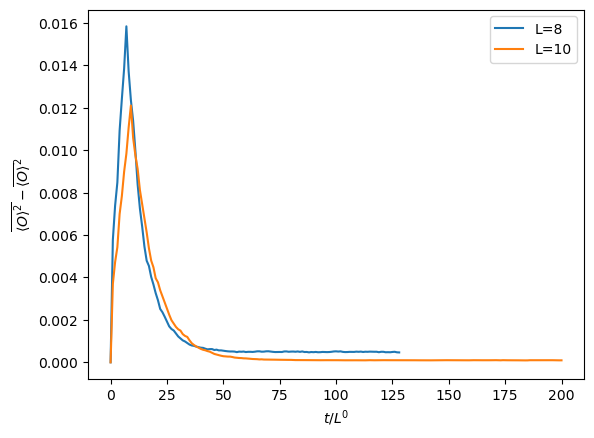

In [96]:
# L=8
fig,ax=plt.subplots()
z=0
for L in [8,10]:
    wf=f_0[L][f'wf_{L}'][0,0].reshape((-1,2**L,2000))
    OP1=Z(L,(0,L))/L
    exp_O=contract(np.abs(wf)**2,[0,1,2],OP1,[1],[0,2])
    var_O= (exp_O**2).mean(axis=-1) - exp_O.mean(axis=-1) **2 
    t_list=np.arange(2*L**2+1)
    ax.plot(t_list/L**z, var_O,label=f'L={L}')

ax.legend()
ax.set_xlabel(f'$t/L^{z}$')  
ax.set_ylabel(r'$\overline{\langle O \rangle^2} - \overline{\langle O \rangle}^2$')

Text(0, 0.5, '$\\overline{\\langle O^2 \\rangle}-\\overline{\\langle O \\rangle^2}$')

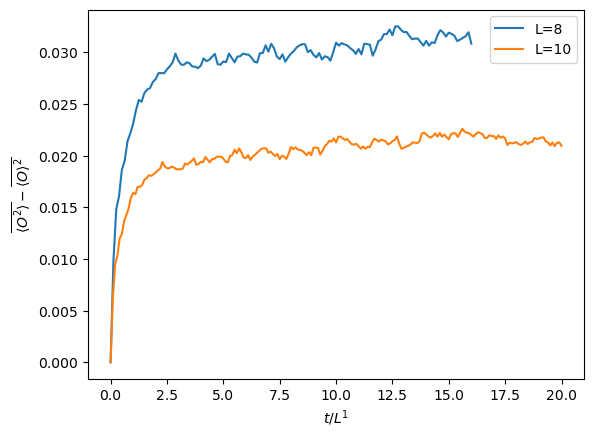

In [90]:
# L=8
fig,ax=plt.subplots()
z=0
for L in [8,10]:
    wf=f_0[L][f'wf_{L}'][12,0].reshape((-1,2**L,2000))
    OP1=Z(L,(0,L))/L
    exp_O=contract(np.abs(wf)**2,[0,1,2],OP1,[1],[0,2])
    exp_O2=contract(np.abs(wf)**2,[0,1,2],OP1**2,[1],[0,2])
    q_var_O= (exp_O2).mean(axis=-1)-(exp_O**2).mean(axis=-1)  
    t_list=np.arange(2*L**2+1)
    ax.plot(t_list/L**z, q_var_O,label=f'L={L}')

ax.legend()
ax.set_xlabel(f'$t/L^{z}$')  
ax.set_ylabel(r'$\overline{\langle O^2 \rangle}-\overline{\langle O \rangle^2}$')

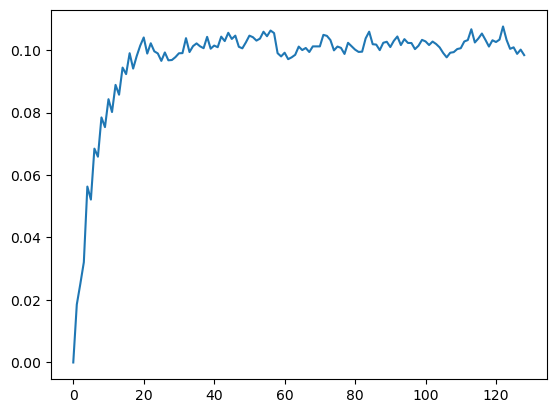

In [34]:
from opt_einsum import contract

In [33]:
L=8
wf=f_0[L][f'wf_{L}'][10,0,0].reshape((2**L,2000))
contract(np.abs(wf)**2,[0,1],OP1,[0],[1])

NameError: name 'contract' is not defined

In [58]:
def Z(L,regime,):
    return np.array([regime[1]-regime[0]-2*bin(idx).replace('0b','').zfill(L)[regime[0]:regime[1]].count('1') for idx in range(2**L)])


In [59]:
L=8
OP1=Z(L,(0,L))/L

In [60]:
OP1

array([ 1.  ,  0.75,  0.75,  0.5 ,  0.75,  0.5 ,  0.5 ,  0.25,  0.75,
        0.5 ,  0.5 ,  0.25,  0.5 ,  0.25,  0.25,  0.  ,  0.75,  0.5 ,
        0.5 ,  0.25,  0.5 ,  0.25,  0.25,  0.  ,  0.5 ,  0.25,  0.25,
        0.  ,  0.25,  0.  ,  0.  , -0.25,  0.75,  0.5 ,  0.5 ,  0.25,
        0.5 ,  0.25,  0.25,  0.  ,  0.5 ,  0.25,  0.25,  0.  ,  0.25,
        0.  ,  0.  , -0.25,  0.5 ,  0.25,  0.25,  0.  ,  0.25,  0.  ,
        0.  , -0.25,  0.25,  0.  ,  0.  , -0.25,  0.  , -0.25, -0.25,
       -0.5 ,  0.75,  0.5 ,  0.5 ,  0.25,  0.5 ,  0.25,  0.25,  0.  ,
        0.5 ,  0.25,  0.25,  0.  ,  0.25,  0.  ,  0.  , -0.25,  0.5 ,
        0.25,  0.25,  0.  ,  0.25,  0.  ,  0.  , -0.25,  0.25,  0.  ,
        0.  , -0.25,  0.  , -0.25, -0.25, -0.5 ,  0.5 ,  0.25,  0.25,
        0.  ,  0.25,  0.  ,  0.  , -0.25,  0.25,  0.  ,  0.  , -0.25,
        0.  , -0.25, -0.25, -0.5 ,  0.25,  0.  ,  0.  , -0.25,  0.  ,
       -0.25, -0.25, -0.5 ,  0.  , -0.25, -0.25, -0.5 , -0.25, -0.5 ,
       -0.5 , -0.75,

In [ ]:
def FDW(L,regime,ZZ):
    # FDW
    FDW_list=[]
    for idx in range(2**L):
        bitstring_reg=bin(idx).replace('0b','').zfill(L)[regime[0]:regime[1]]
        FDW_list.append( bitstring_to_dw(int(bitstring_reg,2),L=regime[1]-regime[0],ZZ=ZZ))
    return np.array(FDW_list)

In [14]:
{bin(idx).replace('0b','').zfill(4):fdw for idx,fdw in enumerate(FDW(4,(0,2),ZZ=True))}

NameError: name 'bitstring_to_dw' is not defined

In [ ]:
FDW(8,)

# Density matrix, coherence

In [ ]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))

In [ ]:
f_0[8]['wf_8'][11].shape

In [ ]:
wf=f_0[8]['wf_8'][15,0,0,...,:,0]

In [ ]:
dm_av=np.einsum(wf,np.r_[np.arange(0,8),16],np.conj(wf),np.r_[np.arange(8,16),16],np.arange(16))/2000

In [ ]:
dm_av0=dm_av.reshape((2**8,2**8))

In [ ]:
np.diag(dm_av0)

In [ ]:
def coherence_resolution(rho,k,normalization=False,average=False):
    L=len(rho.shape)//2
    if k == 0:
        ket_idx=(0,)*L
    else:
        # ket_idx=np.r_[np.zeros((L-k),dtype=int),1]
        ket_idx=(0,)*(L-k)+(1,)+(slice(None),)*(k-1)

    # bra_idx= np.r_[np.zeros((L-k-1),dtype=int),1]
    bra_idx=(0,)*(L-k-1)+(1,)+(slice(None),)*(k)
    tr=trace(rho[ket_idx+ket_idx])+trace(rho[bra_idx+bra_idx])

    # return tr
    coh=np.abs(rho[ket_idx+bra_idx]).sum()

    if normalization:
        coh/=tr.real
    if average:
        coh/=np.prod(rho[ket_idx+bra_idx].shape)
    return coh




In [ ]:
def trace(rho):
    L=len(rho.shape)
    if L>0:
        return np.einsum(rho,list(range(L//2))*2)
    else:
        return rho

In [ ]:
coherence_resolution(dm_av,k=0)

In [ ]:
coherence_resolution(dm_av,k=0,average=True)

In [ ]:
coherence_resolution(dm_av,k=1,average=True)

In [ ]:
coherence_resolution(dm_av,k=2,average=True)

In [ ]:
coherence_resolution(dm_av,k=1)

In [ ]:
coherence_resolution(dm_av,k=2)

In [ ]:
coherence_resolution(dm_av,k=3)

In [ ]:
coherence_resolution(dm_av,k=4)

In [ ]:
coherence_resolution(dm_av,k=5)

In [ ]:
coherence_resolution(dm_av,k=6)

In [ ]:
coherence_resolution(dm_av,k=7)

In [ ]:
coherence_resolution(dm_av,k=2)

In [ ]:
plt.imshow(np.abs(dm_av0)[:12,:12]- np.diag(np.diag(np.abs(dm_av0)[:12,:12])))
plt.colorbar()

In [ ]:
plt.plot([coherence_resolution(dm_av,k=i,average=True) for i in range(7)])

In [ ]:
plt.imshow(np.abs(dm_av0)[:12,:12]- np.diag(np.diag(np.abs(dm_av0)[:12,:12])))
plt.colorbar()

In [ ]:
plt.plot([coherence_resolution(dm_av,k=i,average=True) for i in range(8)])

In [ ]:
plt.imshow(np.abs(dm_av0)[:12,:12]- np.diag(np.diag(np.abs(dm_av0)[:12,:12])))
plt.colorbar()

In [ ]:
plt.plot([coherence_resolution(dm_av,k=i,average=True) for i in range(7)])

In [ ]:
for each k as a function of different L?
average "coherence"?

scaling of coherence (\rho_{0,k}),
thermal dynamic limit, L-> inf


for each trajectory?


In [ ]:
(np.abs(dm_av0-np.diag(np.diag(dm_av0)))).sum()

In [ ]:
def coherence(i,L=8):
    
    wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    dm_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
    dm_av0=dm_av.reshape((2**L,2**L))
    return (np.abs(dm_av0-np.diag(np.diag(dm_av0)))).sum()

In [ ]:
plt.plot([coherence(i) for i in range(21)])

In [ ]:
plt.plot([coherence(i,L=10) for i in range(21)])

In [ ]:
def coherence_each(i,L=8,normalization=True):
    wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    dm_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
    return [coherence_resolution(dm_av,k,normalization=normalization) for k in range(L)]

In [ ]:
coh_map=[coherence_each(i,L=8,normalization=True) for i in range(21)]

In [ ]:
coh_map_raw=[coherence_each(i,L=8,normalization=False) for i in range(21)]

In [ ]:
coh_map_raw10=[coherence_each(i,L=10,normalization=False) for i in range(21)]

In [ ]:
coh_map_raw12=[coherence_each(i,L=12,normalization=False) for i in range(1)]

In [ ]:
plt.pcolormesh(coh_map)

In [ ]:
plt.pcolormesh(np.log(coh_map_raw))

In [ ]:
plt.pcolormesh(np.log(coh_map_raw10))

In [ ]:
plt.plot(np.array(coh_map_raw)[:,0])
plt.plot(np.array(coh_map_raw10)[:,0])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,1])
plt.plot(np.array(coh_map_raw10)[:,1])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,2])
plt.plot(np.array(coh_map_raw10)[:,2])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,3])
plt.plot(np.array(coh_map_raw10)[:,3])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,4])
plt.plot(np.array(coh_map_raw10)[:,4])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,5])
plt.plot(np.array(coh_map_raw10)[:,5])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,6])
plt.plot(np.array(coh_map_raw10)[:,6])

In [ ]:
plt.plot(np.array(coh_map_raw)[:,7])
plt.plot(np.array(coh_map_raw10)[:,7])

In [ ]:
plt.plot(np.array(coh_map_raw10)[:,8])

In [ ]:
plt.plot(np.array(coh_map_raw10)[:,9])

In [ ]:
plt.plot(np.array(coh_map_raw10)[:,8])

In [ ]:
plt.plot([coherence(i,L=12) for i in range(21)])

In [ ]:
dm=np.tensordot(np.conj(wf),wf,axes=0)

In [ ]:
dm0=dm.reshape((2**8,2**8))

In [ ]:
np.zeros((2,))

In [ ]:
np.zeros((3,))

In [ ]:
np.tensordot(np.zeros((2,)),np.zeros((3,)),axes=0).shape

# Obs-del

In [ ]:
import pickle
import numpy as np
import torch

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(8,10,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wf = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(8,10,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf2 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(12,14,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf3 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(14,16,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf4 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(16,18,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf5 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(8,10,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wfs_0_8 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(12,14,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wfs_0_12 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(8,10,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_8 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(10,12,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_10 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(12,14,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_12 = pickle.load(f)

In [ ]:
def convert_tensor(wf,grid=21,kmax=-1):
    wf=torch.stack(wf)
    wf=wf.reshape((grid,grid)+wf.shape[1:])
    wf=torch.mean(torch.abs(wf[...,:kmax,:])**2,axis=(-2,-1)).reshape((grid,grid,-1))
    return wf
    

In [ ]:
wfs_0_8_dist=convert_tensor(wfs_0_8)
wfs_0_12_dist=convert_tensor(wfs_0_12)

In [ ]:
wfs_0_12_dist_half=convert_tensor(wfs_0_12,kmax=1000)
wfs_0_12_dist_quarter=convert_tensor(wfs_0_12,kmax=500)

In [ ]:
wfs_1_3_8_dist=convert_tensor(wfs_1_3_8)
wfs_1_3_10_dist=convert_tensor(wfs_1_3_10)
wfs_1_3_12_dist=convert_tensor(wfs_1_3_12)

In [ ]:
wfs_0_tensor=torch.stack(wfs_0)

In [ ]:
wfs_tensor=torch.stack(wfs)

In [ ]:
torch.where(torch.isnan(wfs_0_tensor))

In [ ]:
230//21,230%21

In [ ]:
wfs_all=wfs_tensor.reshape((21,21)+wfs_tensor.shape[1:])

In [ ]:
wfs_0_all=wfs_0_tensor.reshape((21,21)+wfs_0_tensor.shape[1:])

In [ ]:
dist=(torch.abs(wf[0])**2).mean(axis=(-2,-1)).flatten()

In [ ]:
dist2=(torch.abs(wf2[0])**2).mean(axis=(-2,-1)).flatten()

In [ ]:
dist3=(torch.abs(wf3[0])**2).mean(axis=(-2,-1)).flatten()

In [ ]:
dist4=(torch.abs(wf4[0])**2).mean(axis=(-2,-1)).flatten()

In [ ]:
dist5=(torch.abs(wf5[0])**2).mean(axis=(-2,-1)).flatten()

In [ ]:
wfs_all.shape

In [ ]:
wfs_dist=torch.mean(torch.abs(wfs_all)**2,axis=(-2,-1)).reshape((21,21,-1))

In [ ]:
wfs_0_dist=torch.mean(torch.abs(wfs_0_all)**2,axis=(-2,-1)).reshape((21,21,-1))

In [ ]:
plt.pcolormesh(np.linspace(0,1,21),np.linspace(0,1,21),wfs_dist[:,:,256//3])
plt.colorbar()

In [ ]:
plt.pcolormesh(np.linspace(0,1,21),np.linspace(0,1,21),wfs_0_dist[:,:,0])
plt.colorbar()

In [ ]:
plt.plot(np.linspace(0,1,21),wfs_0_dist[:,0,0]/2,label='0')
plt.plot(np.linspace(0,1,21),wfs_dist[:,0,256//3],label='1/3')
plt.legend()

In [ ]:
wfs_dist[:,:,256//3]

In [ ]:
wfs_dist.shape

In [ ]:
2**(-wfs_dist.shape[-1])

In [ ]:
plt.plot(np.arange(0,1,1/(wfs_dist.shape[-1])),wfs_dist[0,0]*(wfs_dist.shape[-1]))
# plt.plot(x,wfs_dist[10,15])
plt.ylim(0,1.1)

In [ ]:
x=np.linspace(0,1,dist.shape[0])


In [ ]:
plt.plot(x,(dist))

In [ ]:
dist2[256//3-2:256//3+3]

In [ ]:
dist2[256//3*2-2:256//3*2+3]

In [ ]:
dist2[256//3*2-1]

In [ ]:
dist2[256//3*2+1]

In [ ]:
plt.plot(np.linspace(0,1,dist2.shape[0]),(dist2)*dist2.shape[0],'.-')
# plt.plot(np.linspace(0,1,dist3.shape[0]),(dist3)*dist3.shape[0],'-')
# plt.plot(np.linspace(0,1,dist4.shape[0]),(dist4)*dist4.shape[0],'-')
# plt.plot(np.linspace(0,1,dist5.shape[0]),(dist5)*dist5.shape[0],'-')
# plt.xlim([1/3-.005,1/3+.005])
# plt.yscale('log')

In [ ]:
plt.plot(np.linspace(0,1,dist3.shape[0]),(dist3)*dist3.shape[0])
plt.xlim([1/3-.01,1/3+.01])

In [ ]:
dist3[dist3.shape[0]//3]/dist3[dist3.shape[0]//3+1]

In [ ]:
dist2[dist2.shape[0]//3]/dist2[dist2.shape[0]//3+1]

In [ ]:
dist3[dist3.shape[0]//3]+dist3[dist3.shape[0]//3*2]

In [ ]:
dist2[dist2.shape[0]//3]+dist2[dist2.shape[0]//3*2]

In [ ]:
0b101010101010

In [ ]:
0b010101010101

In [ ]:
4096//3*2

In [ ]:
def generate_bitstring(n):
    l=np.arange(1<<n)
    bin_list=[bin(i)[2:].zfill(n) for i in l]
    bin_list=[[int(b) for b in i] for i in bin_list]

    return np.array(bin_list)

In [ ]:
bitstring=generate_bitstring(12)

In [ ]:
def ZZ(bitstring,k=2):
    n=bitstring.shape[1]
    J=k**np.arange(n-2,-1,-1)
    return np.sum(J*(2*bitstring[:,:-1]-1)*(2*bitstring[:,1:]-1),axis=1)

In [ ]:
def Z(bitstring,k=2):
    n=bitstring.shape[1]
    J=k**np.arange(n-1,-1,-1)
    return np.sum(J*(2*bitstring-1),axis=1)

In [ ]:
def Z_domain(bitstring,k=2):
    dw_pos=[]
    for bs in bitstring:
        pos=0
        while pos<bs.shape[0] and bs[pos]==0:
            pos+=1
        dw_pos.append(bs.shape[0]-pos)

    return np.array(dw_pos)

In [ ]:
def ZZ_domain(bitstring,k=2):
    dw=(2*bitstring[:,:-1]-1)*(2*bitstring[:,1:]-1)
    dw_pos=[]
    for bs in dw:
        pos=0
        while pos<bs.shape[0] and bs[pos]==-1:
            pos+=1
        dw_pos.append(bs.shape[0]-pos)

    return np.array(dw_pos)

In [ ]:
en=Z_domain(bitstring)

In [ ]:
en=ZZ_domain(bitstring)

In [ ]:
plt.plot(en,'.-')

In [ ]:
bitstring

In [ ]:
en

In [ ]:
en=ZZ(bitstring)

In [ ]:
en=Z(bitstring)

In [ ]:
dist2[170]

In [ ]:
plt.scatter(en-en.min()+1,(wfs_1_3_8_dist[10,0])*wfs_1_3_8_dist[10,0].shape[0])
plt.yscale('log')
# plt.xscale('log')

In [ ]:
plt.scatter(en-en.min()+1,(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],s=0.5)
plt.yscale('log',base=2)
# plt.xscale('log')

In [ ]:
import pandas as pd

In [ ]:
df=pd.DataFrame({'en':en,'p':wfs_0_12_dist[10,0]*wfs_0_12_dist[10,0].shape[0]})
df_half=pd.DataFrame({'en':en,'p':wfs_0_12_dist_half[10,0]*wfs_0_12_dist_half[10,0].shape[0]})
df_quarter=pd.DataFrame({'en':en,'p':wfs_0_12_dist_quarter[10,0]*wfs_0_12_dist_quarter[10,0].shape[0]})

In [ ]:
plt.scatter(en,(wfs_0_12_dist_quarter[10,0])*wfs_0_12_dist_quarter[10,0].shape[0],s=0.5,label='500',color='r')
plt.scatter(en,(wfs_0_12_dist_half[10,0])*wfs_0_12_dist_half[10,0].shape[0],s=0.5,label='1000',color='b')
plt.scatter(en,(wfs_0_12_dist[10,0])*wfs_0_12_dist[10,0].shape[0],s=0.5,label='2000',color='y')

plt.yscale('log',base=2)
# plt.xscale('log')
plt.legend()

In [ ]:
plt.plot(df.groupby('en').mean())

In [ ]:
fig,ax=plt.subplots()
df.groupby('en').mean().plot(ax=ax,label='2000')
df_half.groupby('en').mean().plot(ax=ax,label='1000')

ax.legend()
ax.set_yscale('log')

In [ ]:
plt.plot(df['en'],df['p'],'.')
plt.yscale('log')

In [ ]:
plt.scatter(en,(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],s=0.5)
plt.yscale('log',base=2)
# plt.xscale('log')

In [ ]:
en=Z(bitstring,k=2)

In [ ]:
plt.scatter(en,(dist)*dist.shape[0],s=0.5)
plt.yscale('log')
# plt.xscale('log')

In [ ]:
plt.scatter(np.linspace(0, 10),np.exp(-np.linspace(0, 10)**1))
plt.yscale(value='log')

In [ ]:
plt.plot(np.linspace(0,1,dist.shape[0]),(dist)*dist.shape[0],'.-')
plt.yscale('log')
plt.xscale('log')
for i in np.arange(1,8):
    plt.axvline(x=1/2**i,ls='dashed')

In [ ]:
np.log2(wfs_0_12_dist.shape[-1])

## Distribution of xj=0

In [ ]:
fig,ax=plt.subplots()

ax.plot(np.arange(0,1,1/wfs_0_8_dist[12,0].shape[0])+1/wfs_0_8_dist[12,0].shape[0],(wfs_0_8_dist[12,0])*wfs_0_8_dist[12,0].shape[0],'.-',markersize=3,label='L=8')

ax.plot(np.arange(0,1,1/wfs_0_10_dist[12,0].shape[0])+1/wfs_0_10_dist[12,0].shape[0],(wfs_0_10_dist[12,0])*wfs_0_10_dist[12,0].shape[0],'.-',markersize=3,label='L=8')

ax.plot(np.arange(0,1,1/wfs_0_12_dist[12,0].shape[0])+1/wfs_0_12_dist[12,0].shape[0],(wfs_0_12_dist[12,0])*wfs_0_12_dist[12,0].shape[0],'.-',markersize=3,label='L=12')

ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

In [ ]:
fig,ax=plt.subplots()
p_list=np.linspace(0,1,21)
for i in [10,12,14]:
    ax.plot(np.arange(0,1,1/wfs_0_12_dist[i,0].shape[0])+1/wfs_0_12_dist[i,0].shape[0],(wfs_0_12_dist[i,0])*wfs_0_12_dist[i,0].shape[0],'.-',markersize=3,label=f'p_ctrl={p_list[i]:.2f}')

ax.legend()
ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

In [ ]:
plt.plot([torch.mean(wfs_0_12_dist[10,0][2**i:2**(i+1)])*wfs_0_12_dist[10,0].shape[0] for i in range(12)],'.-')
plt.yscale('log')

In [ ]:
fig,ax=plt.subplots()
p_list=np.linspace(0,1,21)
for i in [0,5,]:
    ax.plot(np.arange(0,1,1/wfs_0_12_dist[10,i].shape[0])+1/wfs_0_12_dist[10,i].shape[0],(wfs_0_12_dist[10,i])*wfs_0_12_dist[10,i].shape[0],'.-',markersize=3,label=f'p_proj={p_list[i]:.2f}',alpha=0.4)

ax.legend()
ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

## Distribution of xj={1/3,2/3}

In [ ]:
wfs_1_3_8_dist[10,0].shape[0]

In [ ]:
def generate_distance_1_3(wf):
    bitstring_1_3=np.arange(0,1,1/wf.shape[0])
    bitstring_1_3_distance=np.abs(np.r_[bitstring_1_3[:bitstring_1_3.shape[0]//2]-bitstring_1_3[bitstring_1_3.shape[0]//3],bitstring_1_3[bitstring_1_3.shape[0]//2:]-bitstring_1_3[bitstring_1_3.shape[0]//3*2]])
    return bitstring_1_3_distance

In [ ]:
fig,ax=plt.subplots()
# ax.plot(generate_distance_1_3(wfs_1_3_8_dist[10,0]),(wfs_1_3_8_dist[10,0])*wfs_1_3_8_dist[10,0].shape[0],'.',markersize=3,label='L=8')
ax.plot(generate_distance_1_3(wfs_1_3_12_dist[10,0]),(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],'.',markersize=3,label='L=12')
# ax.plot(np.linspace(0,1,wfs_1_3_12_dist[12,0].shape[0])+1/wfs_1_3_12_dist[12,0].shape[0],(wfs_1_3_12_dist[12,0])*wfs_1_3_12_dist[12,0].shape[0],'.-',markersize=3,label='L=12')


ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

In [ ]:
fig,ax=plt.subplots()
ax.plot(generate_distance_1_3(wfs_1_3_12_dist[10,0]),(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],'.',markersize=3,label='1/3')

ax.plot(np.arange(0,1,1/wfs_0_12_dist[10,0].shape[0]),(wfs_0_12_dist[10,0])*wfs_0_12_dist[10,0].shape[0],'.',markersize=3,label='0')



ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')
ax.legend()

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

In [ ]:
plt.plot(np.linspace(0,1,dist2.shape[0]),(dist2)*dist2.shape[0],'.-')
plt.yscale('log')

In [ ]:
str(2<<1)

In [ ]:
check correlation , FWHM, fit lorentzian
peak,FWHM as a function of (p_ctrl, p_proj,)
what curve is best fit? Does not look like Lorenzian because it seems unbounded at the center, well could be just gaussian, where the sigma is infinitely small? lorentzian is also possible though. because both distributions have 1/lw at the center 
is there any hamiltonian describe this?

can we have a Heisenberg model where the J is like 2^n?